# Scripts

In [167]:
%run '../shared-code/utils.py'

# Dependencies

In [239]:
import pandas as pd 
import joblib
import matplotlib.pyplot as plt 
from sklearn.linear_model import Ridge,Lasso,LinearRegression,ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error,make_scorer
import numpy as np
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score,HalvingGridSearchCV,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
import copy 
import sklearn
from sklearn.pipeline import FunctionTransformer
from sklearn.compose import make_column_transformer
import scipy 

%matplotlib inline 

# Utils 

In [170]:
import sklearn.pipeline

def feat_imp(cols: np.ndarray, coefs):
    df = pd.DataFrame(index=cols, columns=["Imp"], data=coefs)

    plt.figure(figsize=(50, 25))
    sns.barplot(y=cols, x=coefs)
    plt.show()

    return df

def process_and_split(X: pd.DataFrame, pipe: sklearn.pipeline.Pipeline):
    X_proc = pipe.transform(X)
    return train_test_split(
        X_proc.drop("SalePrice", axis=1),
        X_proc["SalePrice"],
 
        random_state=42,
        test_size=0.2,
    )
    
def cols_corr_in_range(i:int,corr:pd.DataFrame):
    weak_feat_query = (corr <= i) & (corr > -i)
    tr_weak_corr = corr[weak_feat_query]["SalePrice"]
    tr_weak_cols = tr_weak_corr[tr_weak_corr.notna()].index.values
    return tr_weak_cols

def val_split(df:pd.DataFrame): 
    X_tr,x_tst,y_tr,y_tst=train_test_split(df.drop(TARGET_COL,axis=1),df[TARGET_COL],test_size=.2,random_state=42)
    x_tr,x_val,y_tr,y_val=train_test_split(X_tr,y_tr,test_size=.2,random_state=42)
    return x_tr,y_tr,x_val,y_val,x_tst,y_tst

def plot_with_correlations(df:pd.DataFrame,corr_vals:list[int],model_constr,**model_args):
    corr = df.corr()
    corr_bounds = corr_vals #[0.1, 0.2,0.3,0.4]
    pref = {b: [] for b in corr_bounds}
    test_pairs = {b: None for b in corr_bounds}

    for i in corr_bounds:
        tr_weak_cols=cols_corr_in_range(i,corr)
        df_st_corr = df.drop(tr_weak_cols, axis=1)
        x_tr,x_tst,y_tr,y_tst=train_test_split(df_st_corr.drop('SalePrice',axis=1),df_st_corr['SalePrice'],random_state=42,test_size=.2)
        test_pairs[i]=(x_tr,y_tr,x_tst,y_tst)

        ln = model_constr(**model_args)
        for j in range(2, 10):
            cvs = cross_val_score(
                ln,
                X=x_tr,
                y=y_tr,
                cv=j,
                scoring=house_pricing_metric,
                n_jobs=-1
            )
            cv = np.mean(cvs)
            pref[i].append(cv)
    
    fig, axs = plt.subplots(
    nrows=1,
    ncols=len(corr_bounds),
    figsize=(30, 10),
    gridspec_kw={
        "wspace": 0.2,
        "hspace": 0.2,
    },
)
    kfolds=list(range(2,10))
    for i,b in enumerate(corr_bounds):
        axs[i].set_title(f"Correlation >|{b}|")
        axs[i].set_ylabel("CV error")
        axs[i].set_xlabel("KFolds")
        sns.lineplot(ax=axs[i], x=kfolds, y=pref[b])

    plt.show() 
    
def plot_alphas_valset(x_tr,y_tr,alphas,model_constr):
    errs=[]
    for alpha in alphas:
        model=model_constr(alpha=alpha,max_iter=int(1e3))
        cvs=cross_val_score(model,X=x_tr,y=y_tr,cv=Kfolds,scoring=house_pricing_metric,n_jobs=-1)
        cv=np.mean(cvs)
        errs.append(cv) 
    
    plt.figure(figsize=(30,10))
    plt.plot(alphas,errs)
    plt.title("CV errors for different alphas")  
    plt.show()
    
    return pd.DataFrame(
        index=alphas,
        data={
            "Errors" : errs
        }
    )

def get_mutlicolinear_features(corr:pd.DataFrame):
    corr=corr[abs(corr)>=.8]
    multi_correlated=set() 
    for i in range(corr.shape[0]):
     for j in range(i): 
        if not pd.isna(corr.iloc[i,j]): 
         multi_correlated.add((corr.index[i],corr.columns[j]))

    multi_correlated=[p[0] for p in multi_correlated]
    return multi_correlated 

# Load & Process train data 

In [171]:
df = pd.read_csv("../data/train.csv",index_col=INDEX_COL)
df.drop("Id", inplace=True, axis=1)
df.sample(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Index,,,,,,,,,,,,,,,,,,,,,
976,30,RL,51.0,5900,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2006,WD,Normal,85500
816,20,RL,NaN,11425,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,137000


In [172]:
X_tr,y_tr=df.drop(TARGET_COL,axis=1),df[TARGET_COL]

In [173]:
data_pipe: sklearn.pipeline.Pipeline =joblib.load('../pipelines/data_pipeline.pkl') 
data_pipe.fit(X_tr)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_features at 0x7d87e97ae8c0>)),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature',
                                                   'GarageType', 'GarageFini...
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'Foundation', 'Heating',
                                                   'CentralAir', 'Electrical',
                                                   'GarageType', 'MiscFeature',
                                                   'SaleType', 'SaleCondition',
                                                   'MasVnrType'])])),
                ('functiontransformer-4',
                 FunctionTransformer(func=<__main__.PdWrapper object at 0x7d87e9d4c0d0>)),
                ('functiontransformer-5',
                 FunctionTransformer(func=<function conv_npfloat64 at 0x7d87e808dab0>))])

# Load & Process test data

In [174]:
df_tst=pd.read_csv('../data/test.csv')
X_test,Y_test=df_tst.drop(TARGET_COL,axis=1),df_tst[TARGET_COL]
data_pipe.transform(X_test).describe()

,LotShape,LandContour,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,Bsmt1Type,Bsmt2Type,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,AgeFromLastRemodelingPriSale
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,...,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000
mean,2.643836,2.743151,1.924658,2.400685,2.068493,3.479452,2.914384,1.671233,3.582192,1.263699,...,459.804795,87.434932,34.986301,22.414384,1.797945,13.674658,1.972603,12.376712,6.184932,23.065068
std,0.546651,0.707681,0.312085,0.574725,0.302510,0.909810,0.582858,1.116016,2.143501,0.950122,...,224.206933,106.111686,50.049184,57.199562,17.941206,55.333233,33.707850,79.339770,2.832078,20.377010
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,3.000000,2.000000,2.000000,2.000000,3.000000,3.000000,1.000000,1.000000,1.000000,...,303.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000
50%,3.000000,3.000000,2.000000,2.000000,2.000000,4.000000,3.000000,1.000000,4.000000,1.000000,...,451.500000,26.000000,13.500000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,15.000000
75%,3.000000,3.000000,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,6.000000,1.000000,...,576.000000,168.000000,53.250000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,39.000000
max,3.000000,3.000000,2.000000,4.000000,3.000000,5.000000,4.000000,4.000000,6.000000,6.000000,...,1390.000000,466.000000,274.000000,318.000000,238.000000,396.000000,576.000000,600.000000,12.000000,60.000000


# Linear regression 

In [175]:
ln = LinearRegression()
ln.fit(data_pipe.transform(X_tr), y_tr)

LinearRegression()

In [176]:
rmse_logs(Y_test, ln.predict(data_pipe.transform(X_test)))

1.5848384489715932

In [177]:
np.log(y_tr.min()),np.log(y_tr.max())

(10.460242108190519, 13.521139497361697)

Deka rabotame so logs znachit 0.2 ne e bash najgolema ghreska, zemeno deka log rangot na ***SalePrice*** e (10.5,13.5)

In [178]:
X_tr_proc:pd.DataFrame=data_pipe.transform(X_tr)

<Figure size 640x480 with 0 Axes>

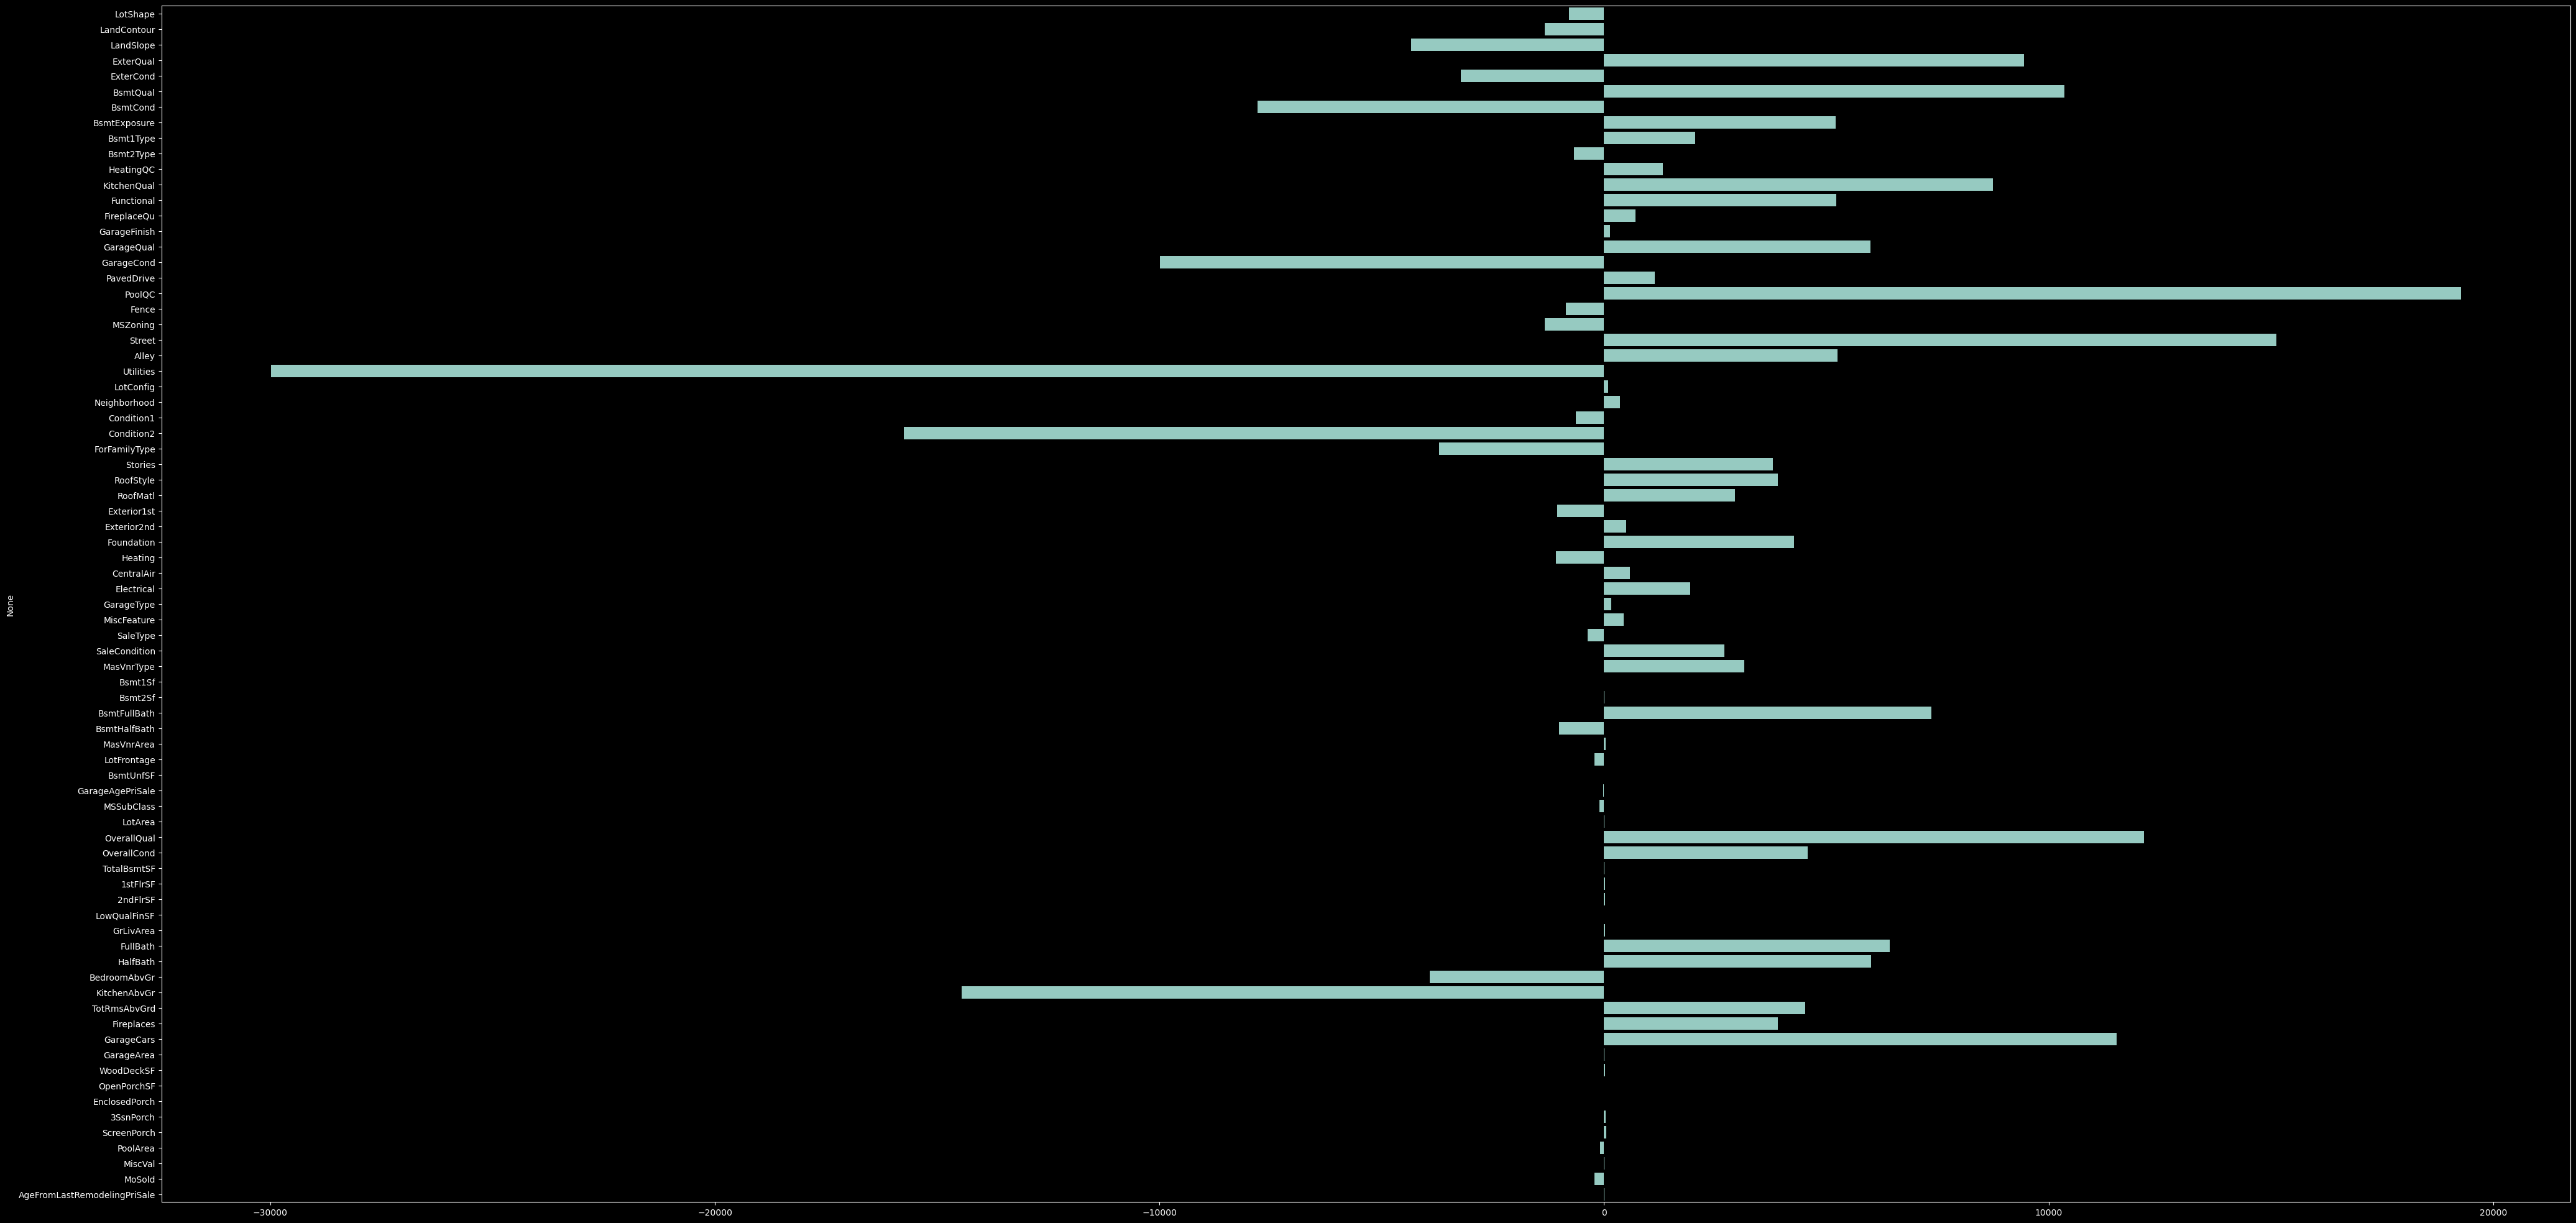

In [179]:
imp = feat_imp(X_tr_proc.columns, ln.coef_)

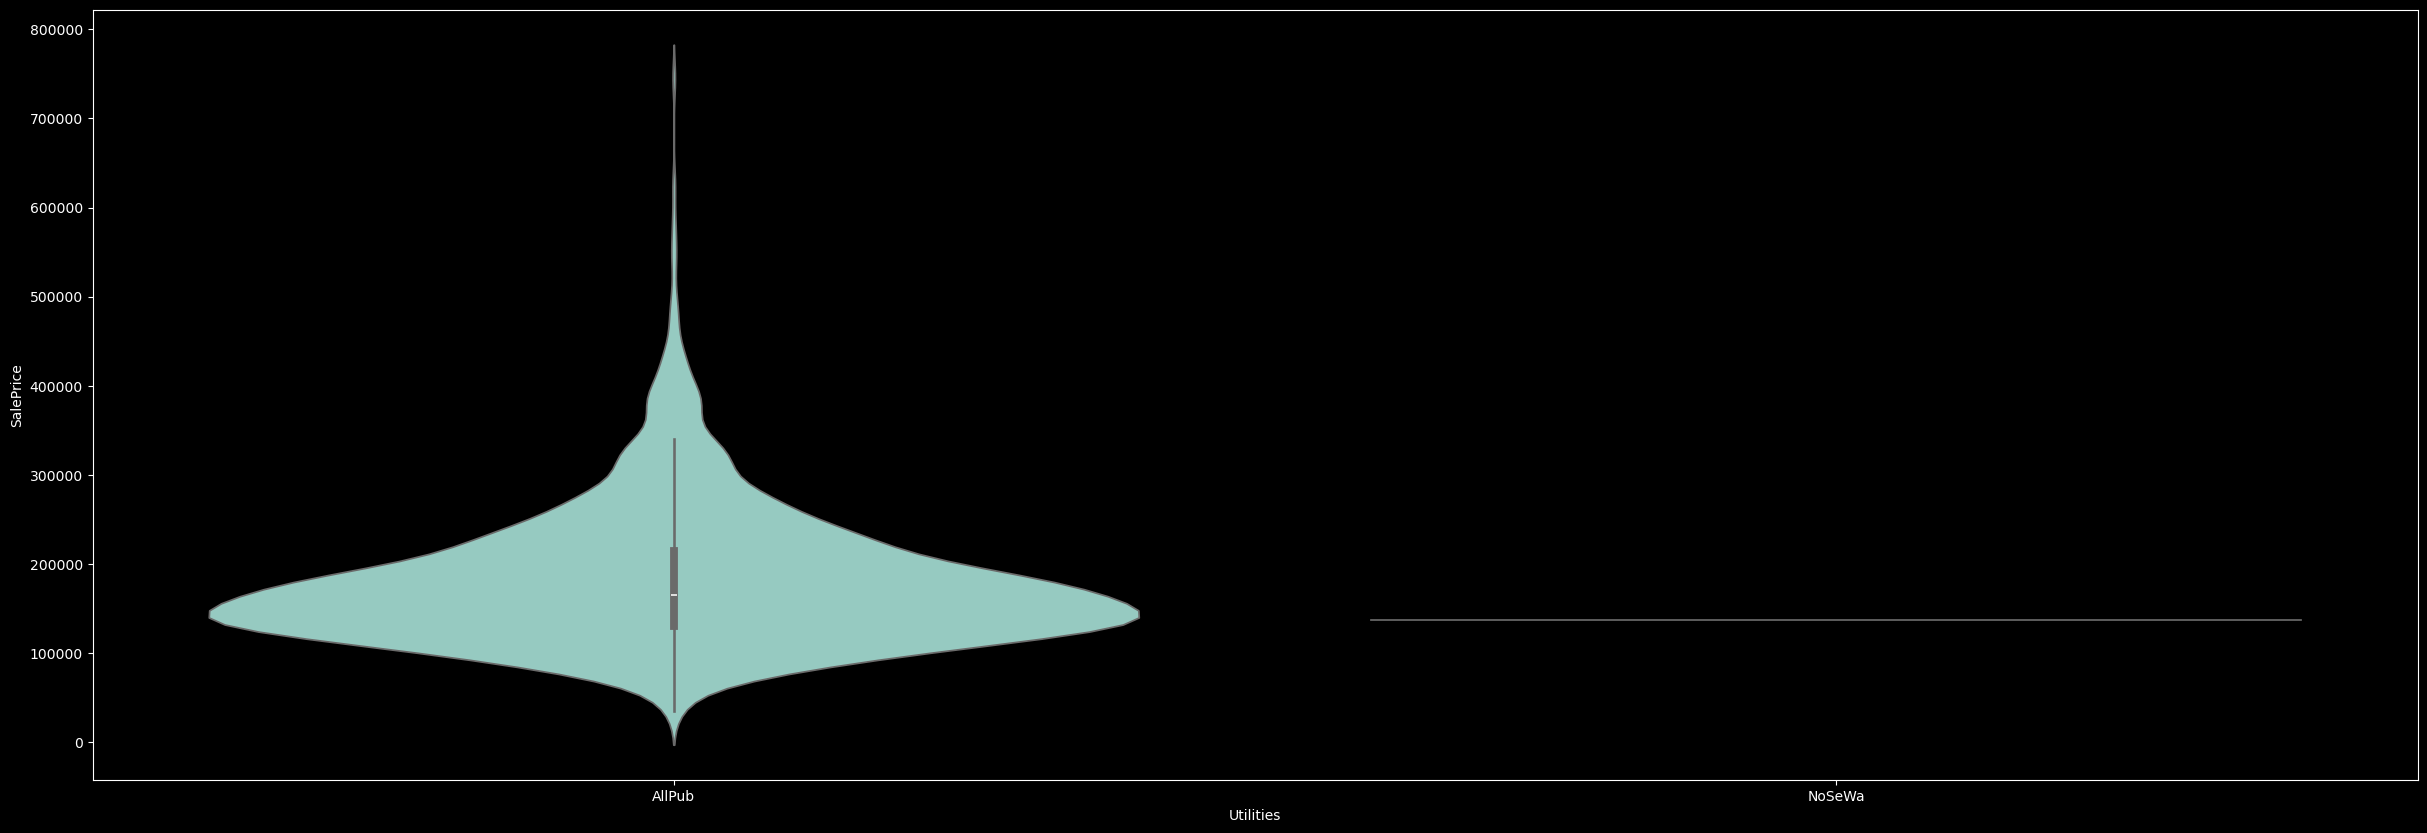

In [180]:
plt.figure(figsize=(30, 10))
sns.violinplot(y=df["SalePrice"], x=df["Utilities"])
plt.show()

In [181]:
df["Utilities"].value_counts().map(lambda x: x / df.shape[0])

Utilities
AllPub    0.999144
NoSeWa    0.000856
Name: count, dtype: float64

In [182]:
X_tr_proc["Utilities"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1163    0.0
1164    0.0
1165    0.0
1166    0.0
1167    0.0
Name: Utilities, Length: 1168, dtype: float64

Imat smisla zsh e tolku negativno. Smeshnoto e sho nemat ni da imat effekt deka 99% od samples imat 0 vrednost za ovaj feature. Zto imat smisla

## Improvments 

### Feature scalling 

In [183]:
data_pipe_scalling = copy.deepcopy(data_pipe)
scaller = make_column_transformer(
    (MinMaxScaler(), X_tr_proc.columns),
    remainder="passthrough" 
)
data_pipe_scalling.steps.append(("Scalling", scaller))
data_pipe_scalling.steps.append(("Back to df", FunctionTransformer(func=PdWrapper(scaller))))
data_pipe_scalling.fit(X_tr)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_features at 0x7d87e97ae8c0>)),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature',
                                                   'GarageType', 'GarageFini...
       'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'AgeFromLastRemodelingPriSale'],
      dtype='object'))])),
                ('Back to df',
                 FunctionTransformer(func=<__main__.PdWrapper object at 0x7d87d8d57cd0>))])

In [184]:
data_pipe_scalling.transform(X_tr).describe()

,LotShape,LandContour,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,Bsmt1Type,Bsmt2Type,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,AgeFromLastRemodelingPriSale
count,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,0.859589,0.944064,0.970462,0.464897,0.521832,0.698288,0.735017,0.404966,0.589469,0.207192,...,0.335877,0.111957,0.090638,0.039563,0.007505,0.032099,0.004005,0.003308,0.486924,0.392151
std,0.196793,0.192477,0.133283,0.191470,0.090549,0.173666,0.136088,0.263782,0.349930,0.146278,...,0.148868,0.151325,0.126935,0.112470,0.062047,0.116419,0.056434,0.035680,0.242792,0.339583
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.666667,1.000000,1.000000,0.333333,0.500000,0.600000,0.750000,0.250000,0.166667,0.166667,...,0.240480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.363636,0.081967
50%,1.000000,1.000000,1.000000,0.333333,0.500000,0.800000,0.750000,0.250000,0.666667,0.166667,...,0.339915,0.000000,0.049360,0.000000,0.000000,0.000000,0.000000,0.000000,0.454545,0.245902
75%,1.000000,1.000000,1.000000,0.666667,0.500000,0.800000,0.750000,0.500000,1.000000,0.166667,...,0.406206,0.196033,0.135283,0.000000,0.000000,0.000000,0.000000,0.000000,0.636364,0.704918
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [185]:
ln = LinearRegression()
ln.fit(data_pipe_scalling.transform(X_tr), y_tr)

LinearRegression()

In [186]:
rmse_logs(Y_test, ln.predict(data_pipe_scalling.transform(X_test)))

1.5848384489715932

Znachit scaleot na features ne mu menvit mnogu. To go sfakame so to sho imame skros ist rezultat 

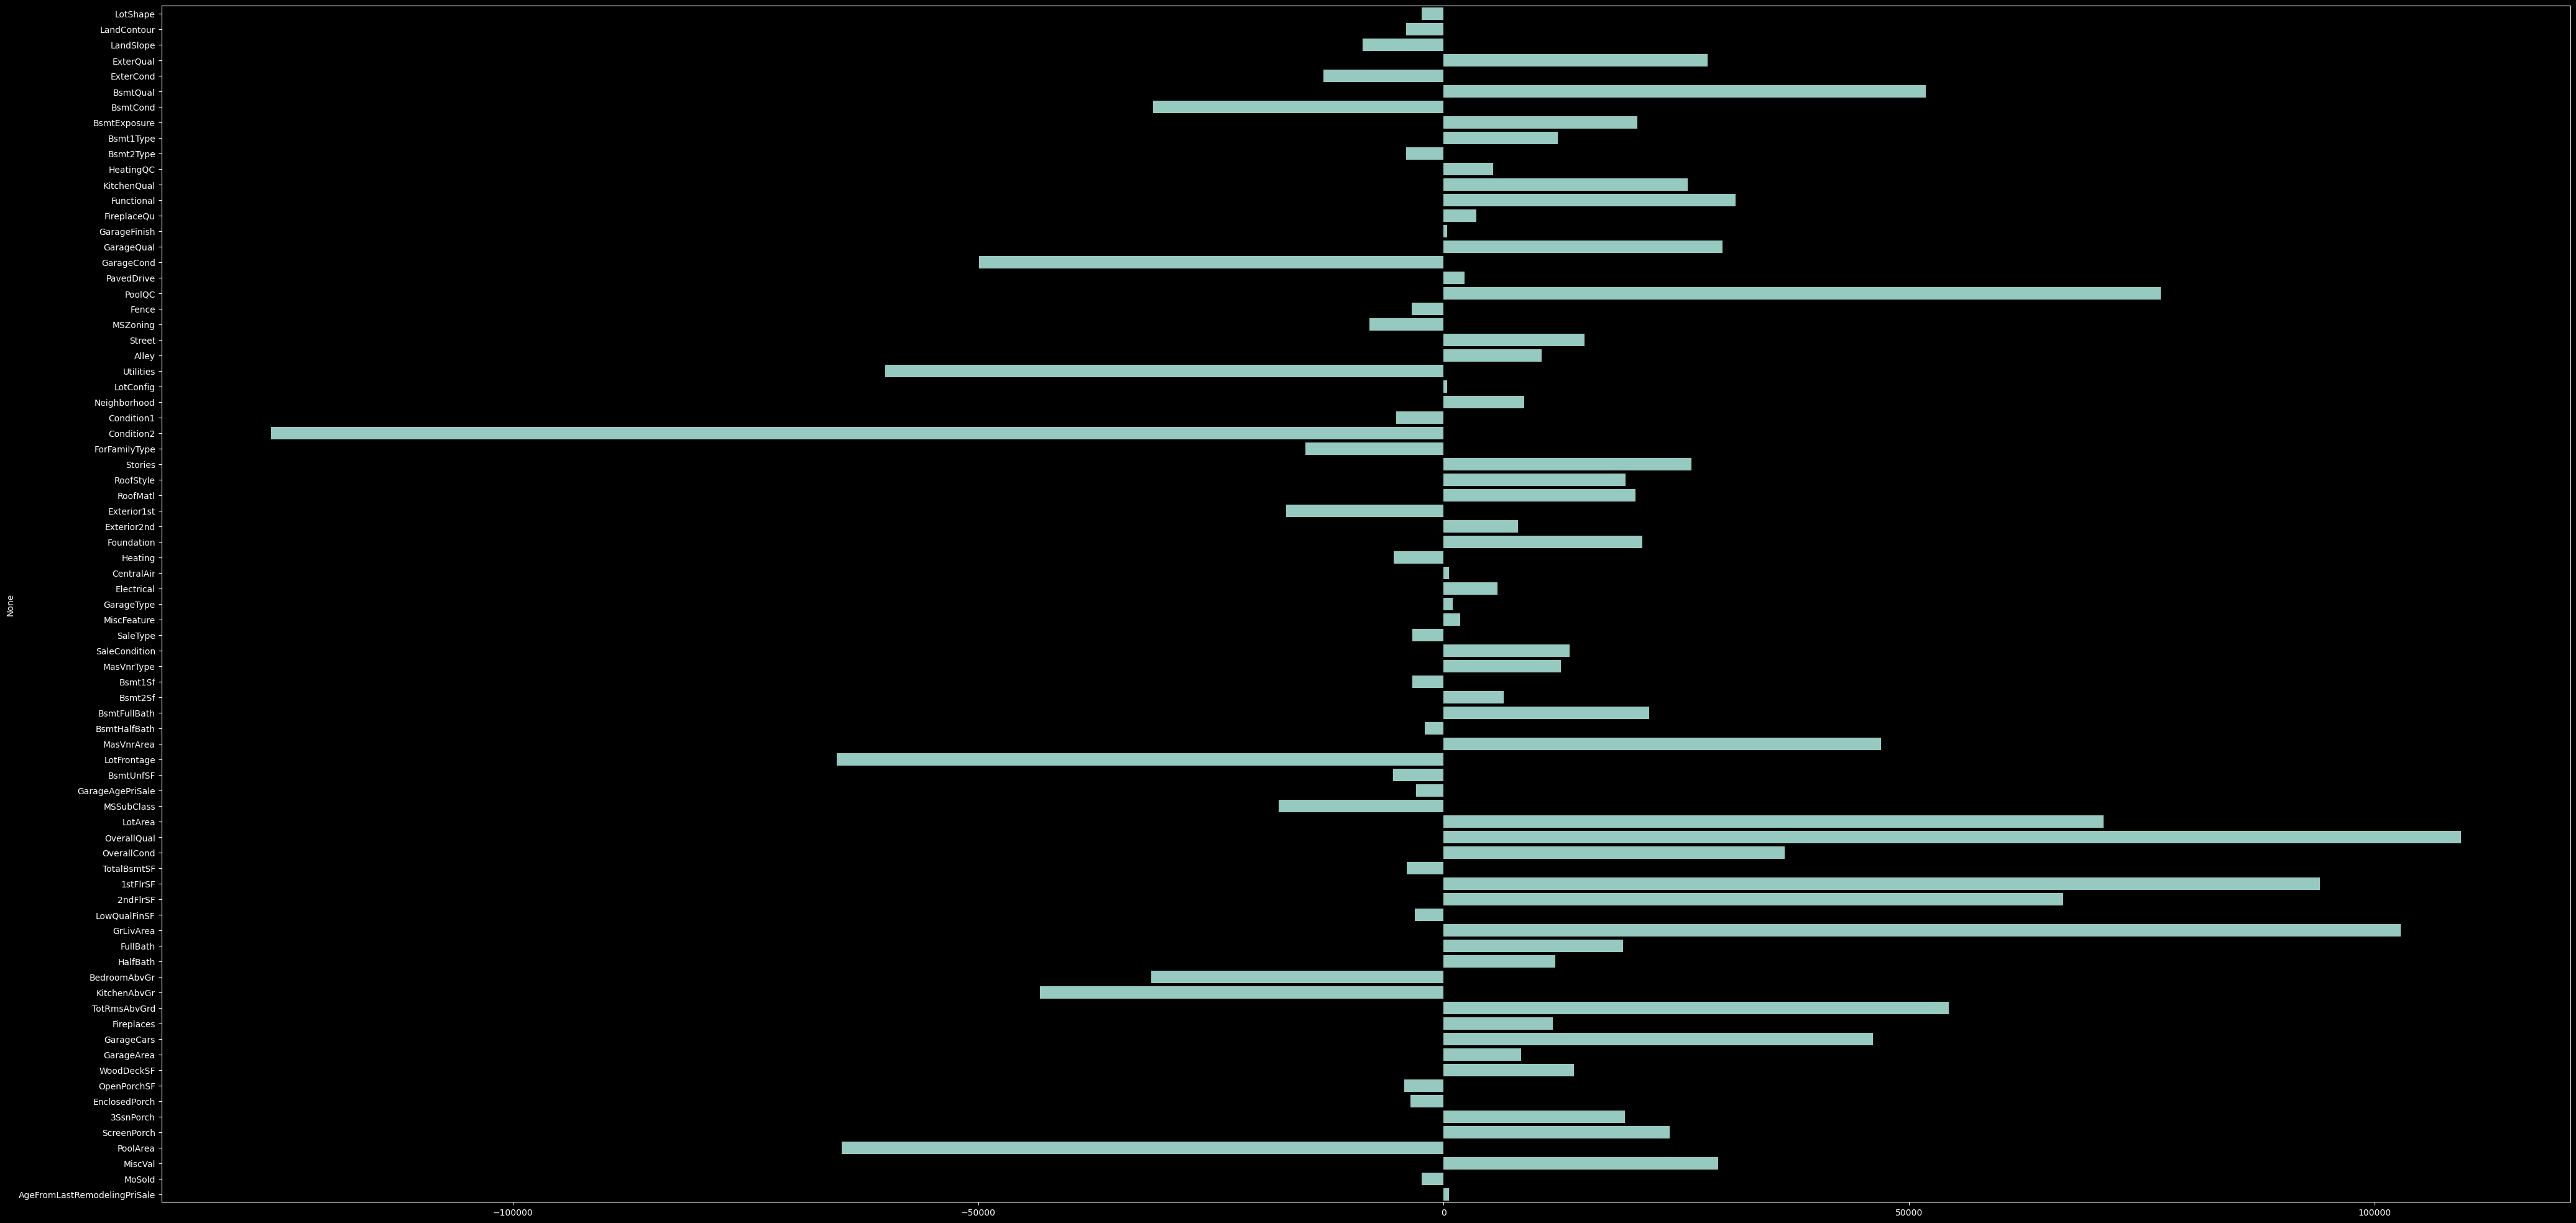

In [187]:
df_feat_imp = feat_imp(X_tr_proc.columns, ln.coef_)

Iako nemat neshto golem improvment vo odnos na grehskata. Feature importanceot imat pojke smisla. Ne e samo Utility toj sho turkat dolu. Ova bash ubavo ni ja ilustriat potrebata od scalling vo vakvite modeli. Prethodno tie features sho imaja mnogu golemi vrednosti bea pozitivni, sega otkako so scallingot naprevme site ednakvo da se vazhi za modelot, dobivame podobra distribucija na weights. 

In [188]:
df_proc=data_pipe_scalling.transform(df)
df_proc.index=copy.deepcopy(df.index) 
df_proc=pd.concat([df_proc,y_tr],axis=1)
corr=df_proc.corr()
ng_corr=df_proc.columns[corr[corr < -0.5]["SalePrice"].notna().values]
ng_corr

Index(['AgeFromLastRemodelingPriSale'], dtype='object')

Gi zemame site features so koi targetot e negativno koreliran, so cel posle da vidime kakvi weights mu assignvit. 

In [189]:
df_feat_imp.loc[ng_corr.values].min().values[0], df_feat_imp.loc[ng_corr.values].max().values[0]

(603.0886881460028, 603.0886881460028)

In [190]:
df_feat_imp.min()[0],df_feat_imp.max()[0]

(-125990.47884097196, 109269.45570829048)

Golemite vrednosti za weights se dolzhi na scallingot,no to e zaradi toa shto normalno e pogolemi weights da mu davat, deka ***SalePrice*** e dosta golem feature i mu trebat na nekoj nachin da kompenzirat za malite vrednosti ((0,1)) za features. 

### Dropping features with weak correlation 

Najprvin zoshto gore velev deka sakame da go overfitnime modelov. Ako go overvitnime modelov doznavame koja e maksimalnata preciznost sho mozhit da ja dobiet, so to zneme i kolku kompleksen datasetot sprema kolku e kompleksen modelot. Preku toj ratio na kompleksnost doznavame dali treba da ojme so nekoj ushte pokompleksen model, ako ovaj ne vrshit rabota. 

Najprvin da vidime kolku sakame da e golemo validaciskoto mnozestvo. Ova go preme so cel da dovolno golem dataset, na koj bi mozhele da go testirame modelot.  

In [191]:
portions = []
sz_df = df.shape[0]
for i in range(2, 11):
    tr_size = (sz_df / i) * (i - 1)
    portions.append(tr_size / sz_df)
portions

[0.5,
 0.6666666666666666,
 0.75,
 0.7999999999999999,
 0.8333333333333333,
 0.8571428571428571,
 0.875,
 0.8888888888888888,
 0.9]

### Features with weak correlation 

In [192]:
cols_corr_in_range(i=0.4,corr=df_proc.corr()).shape[0]

59

Znachit deka imame mnogu weak correlation features. Sho znachit trebat malce granicite da gi obnovime, deka sigurno nemat da dropnime 59 features.

In [193]:
cols_corr_in_range(i=0.1,corr=df_proc.corr()).shape[0]

20

Ke probame so granica 0.1 i 0.2. Deka eptem mnogu losho e 0.2 sho mislat deka ke kompenzirat za brojot na features sho trebat da gi dropnime. 

In [194]:
df['SalePrice'].max()

745000

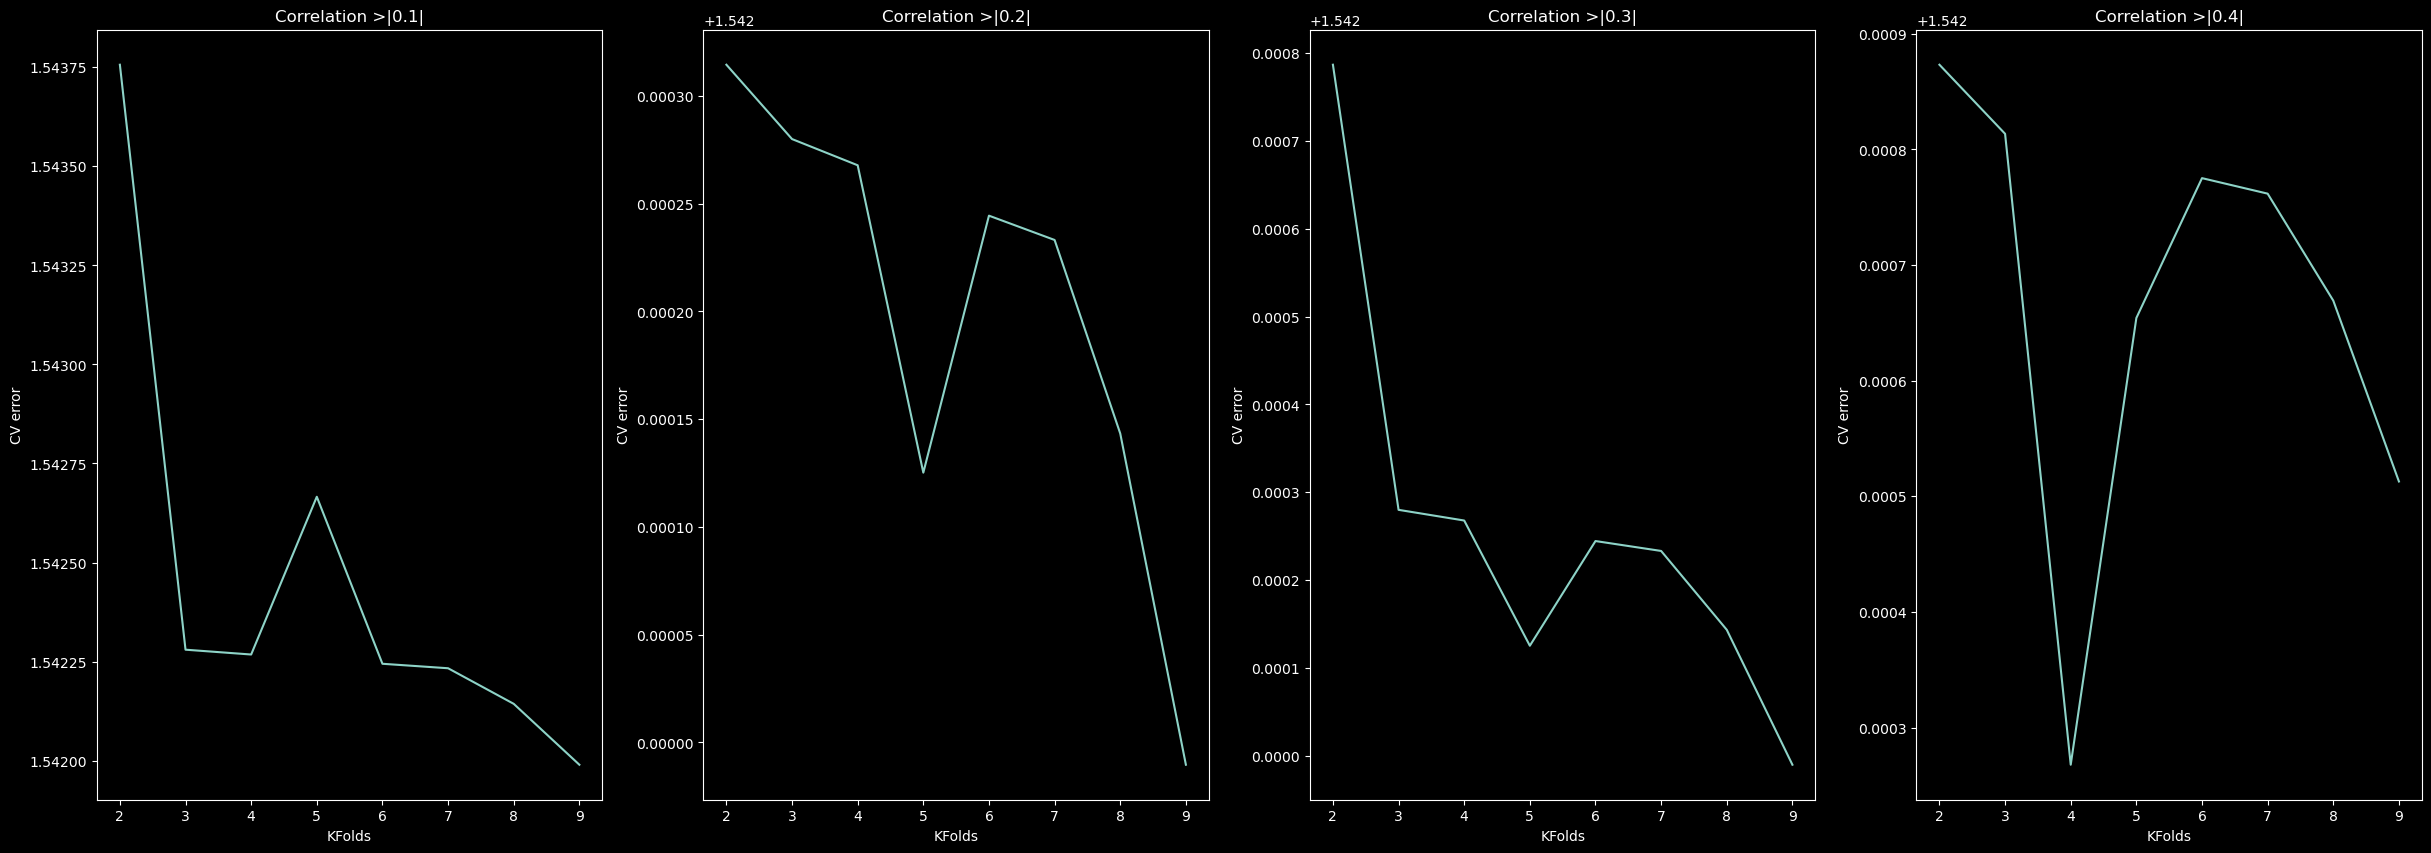

In [195]:
plot_with_correlations(df_proc,corr_vals=[0.1, 0.2,0.3,0.4],model_constr=LinearRegression)

Ochekuvano e deka za pogolemi vrednosti na folds ke imat podobri rezultati. Sepak idejata tuka mi beshe da vidime on average za razlichni test folds kako se odnesuvat modelot, odnosno kolku dobro generalizirat.

Za correlation >0.2 i >0.3 davat dobri rezultati, sho znachit deka bilo koj od niv mozhit posle da go upotrebime na test datasetot. 

In [196]:
wk_cols=cols_corr_in_range(i=.3,corr=df_proc.corr())
data_pipe_drop=copy.deepcopy(data_pipe_scalling)
data_pipe_drop.steps.append(('Drop weak cols',FunctionTransformer(lambda x: x.drop(wk_cols,axis=1))))
data_pipe_drop.fit(X_tr)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_features at 0x7d87e97ae8c0>)),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature',
                                                   'GarageType', 'GarageFini...
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'AgeFromLastRemodelingPriSale'],
      dtype='object'))])),
                ('Back to df',
                 FunctionTransformer(func=<__main__.PdWrapper object at 0x7d87d8a8dab0>)),
                ('Drop weak cols',
                 FunctionTransformer(func=<function <lambda> at 0x7d87e98464d0>))])

In [197]:
ln=LinearRegression() 
ln.fit(data_pipe_drop.transform(X_tr),y_tr)

LinearRegression()

In [198]:
rmse_logs(Y_test,ln.predict(data_pipe_drop.transform(X_test))) 

1.5848384489715932

Ochigledno dobivame podobri rezultati. Toa ni davat na znaenje deka modelot imat mnogu features koj probvit da gi sklopit vo prediction, no mu prat teret, odnosno mu ja namalvat preciznosta. 

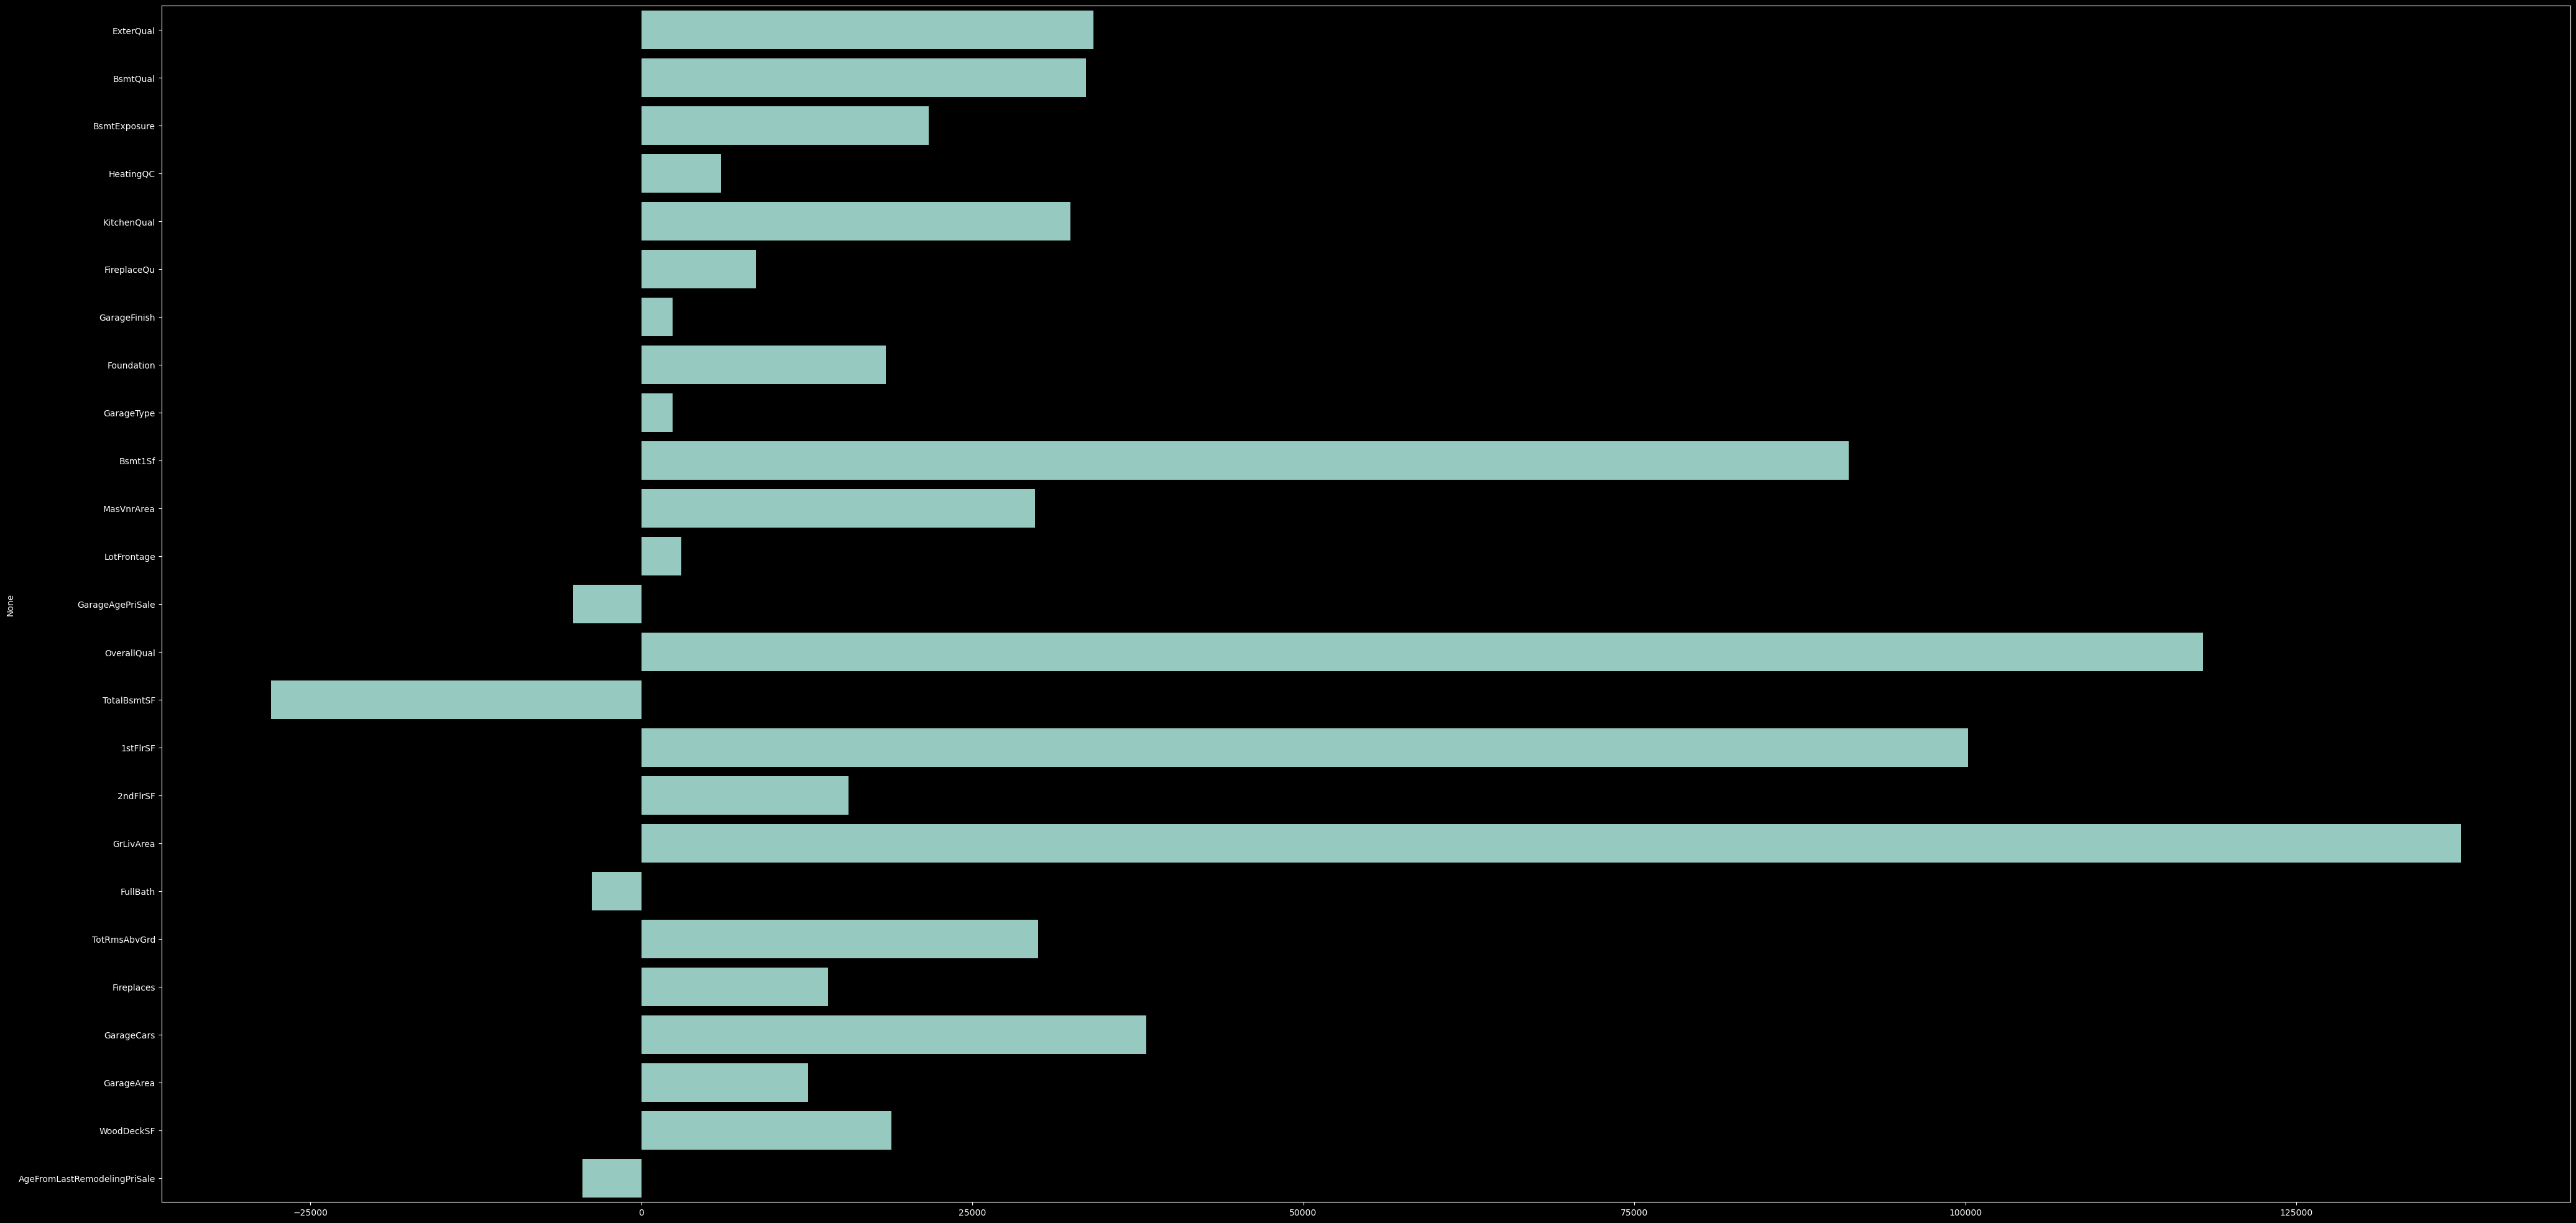

In [199]:
X_tr_proc=data_pipe_drop.transform(X_tr)
_=feat_imp(X_tr_proc.columns,ln.coef_)

# Problem 
Dali da ojme so multicolinearity od weak ili od site

## Dropping multicolinearity & weak features

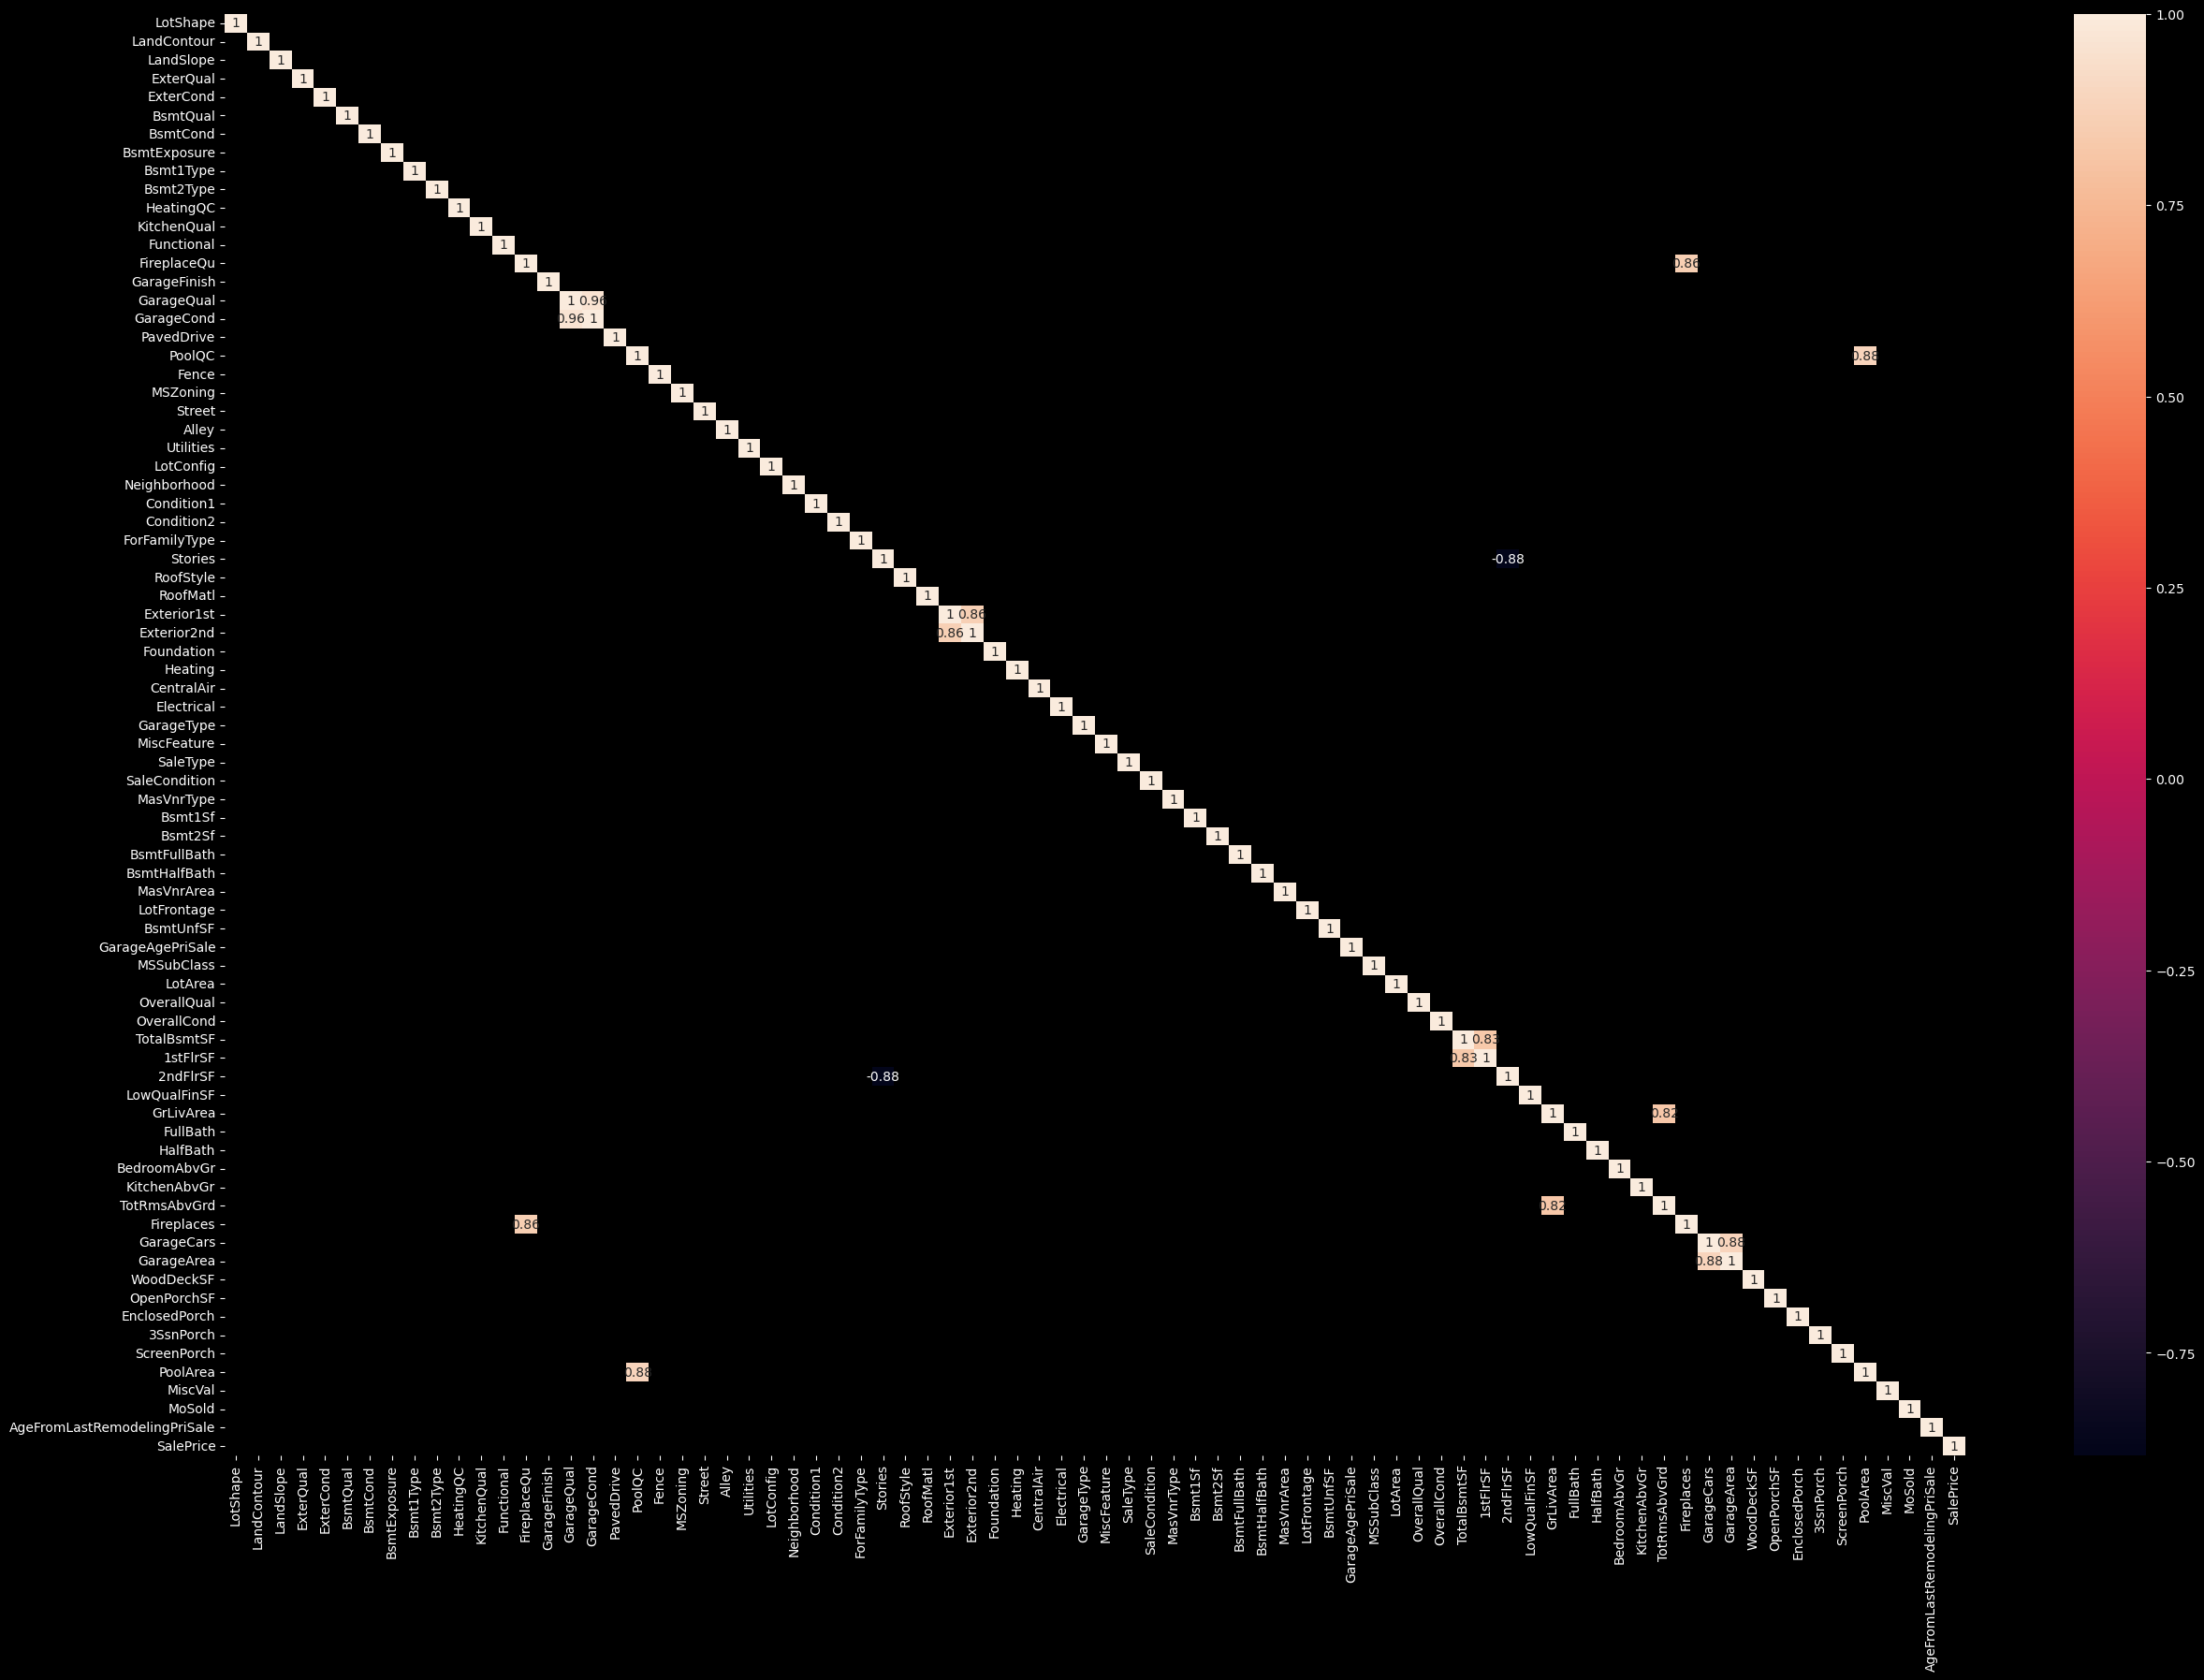

In [200]:
plt.figure(figsize=(30,20))
corr=df_proc[df_proc.columns].corr()
corr=corr[abs(corr)>=0.8]
sns.heatmap(corr,annot=True) 
plt.show() 

In [201]:
MULTICOLINEARITY_COLS=get_mutlicolinear_features(corr.copy(deep=True))
MULTICOLINEARITY_COLS

['GarageArea',
 '1stFlrSF',
 'PoolArea',
 'Fireplaces',
 'GarageCond',
 '2ndFlrSF',
 'Exterior2nd',
 'TotRmsAbvGrd']

Bidejki Linearna regresija pretpostavuva deka samo koreliranost pomegu target i ostanatite features, ova multikolinearnost ke ni napret problem. 

In [202]:
ln=LinearRegression() 
X_tr_dropped:pd.DataFrame=data_pipe_drop.transform(X_tr)
after_correlation=[col for col in MULTICOLINEARITY_COLS if col in X_tr_dropped.columns]
X_tr_dropped=X_tr_dropped.drop(after_correlation,axis=1)
ln.fit(X_tr_dropped,y_tr)

LinearRegression()

In [203]:
rmse_logs(Y_test,ln.predict(data_pipe_drop.transform(X_test).drop(after_correlation,axis=1)))

1.5848384489715932

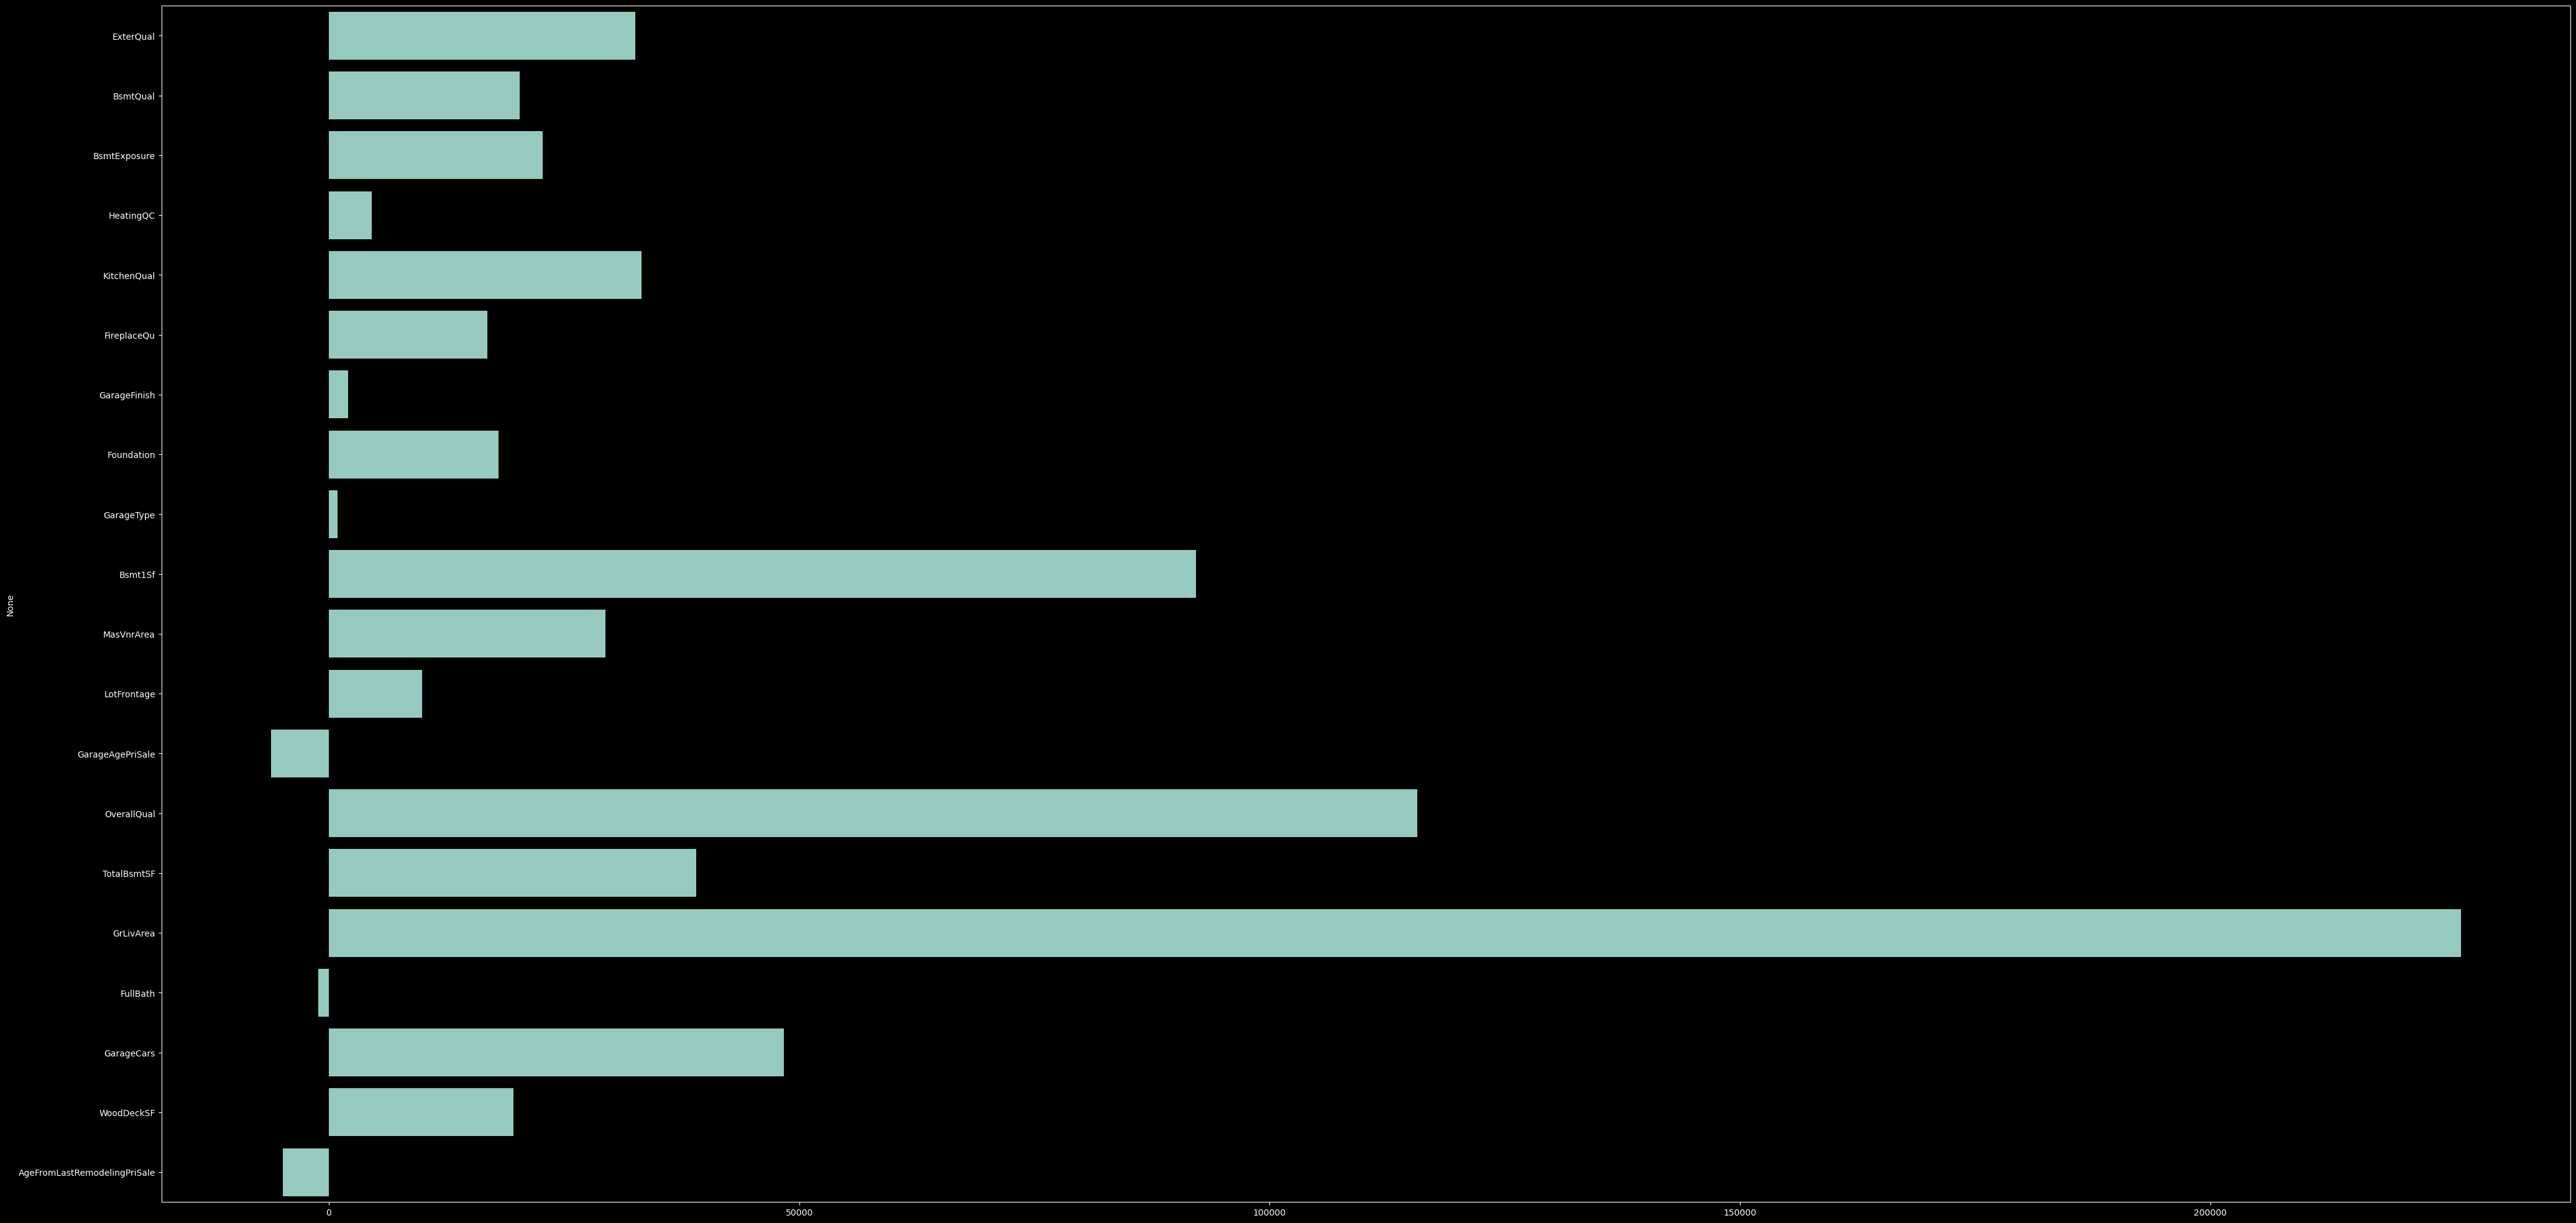

In [204]:
_=feat_imp(X_tr_dropped.columns,ln.coef_)

# Dropping just multi

In [205]:
data_pipe_multi=copy.deepcopy(data_pipe_scalling)
multicolinear_cols=get_mutlicolinear_features(data_pipe_scalling.transform(X_tr).corr())
data_pipe_multi.steps.append(("Remove multicolinear",FunctionTransformer(lambda x: x.drop(multicolinear_cols,axis=1))))
data_pipe_multi.fit(X_tr)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_features at 0x7d87e97ae8c0>)),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature',
                                                   'GarageType', 'GarageFini...
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'AgeFromLastRemodelingPriSale'],
      dtype='object'))])),
                ('Back to df',
                 FunctionTransformer(func=<__main__.PdWrapper object at 0x7d87d8671db0>)),
                ('Remove multicolinear',
                 FunctionTransformer(func=<function <lambda> at 0x7d87d8d3ff40>))])

In [206]:
ln=LinearRegression()
ln.fit(data_pipe_multi.transform(X_tr),y_tr)

LinearRegression()

In [207]:
rmse_logs(Y_test,ln.predict(data_pipe_multi.transform(X_test)))

1.5848384489715932

# Ridge regression 

## Defining ranges for alpha 

In [208]:
large_alphas=np.logspace(start=1,stop=5,base=10,num=60)  # 10 ** 2 ->  10 ** 4 
small_alphas=np.logspace(start=1,stop=10,base=0.1,num=60) # 0.1 -> 0.1 ** 10 

ALPHAS=np.sort(np.concatenate([small_alphas,large_alphas]))

### Finding alpha with cv from non multicolinear dataset 

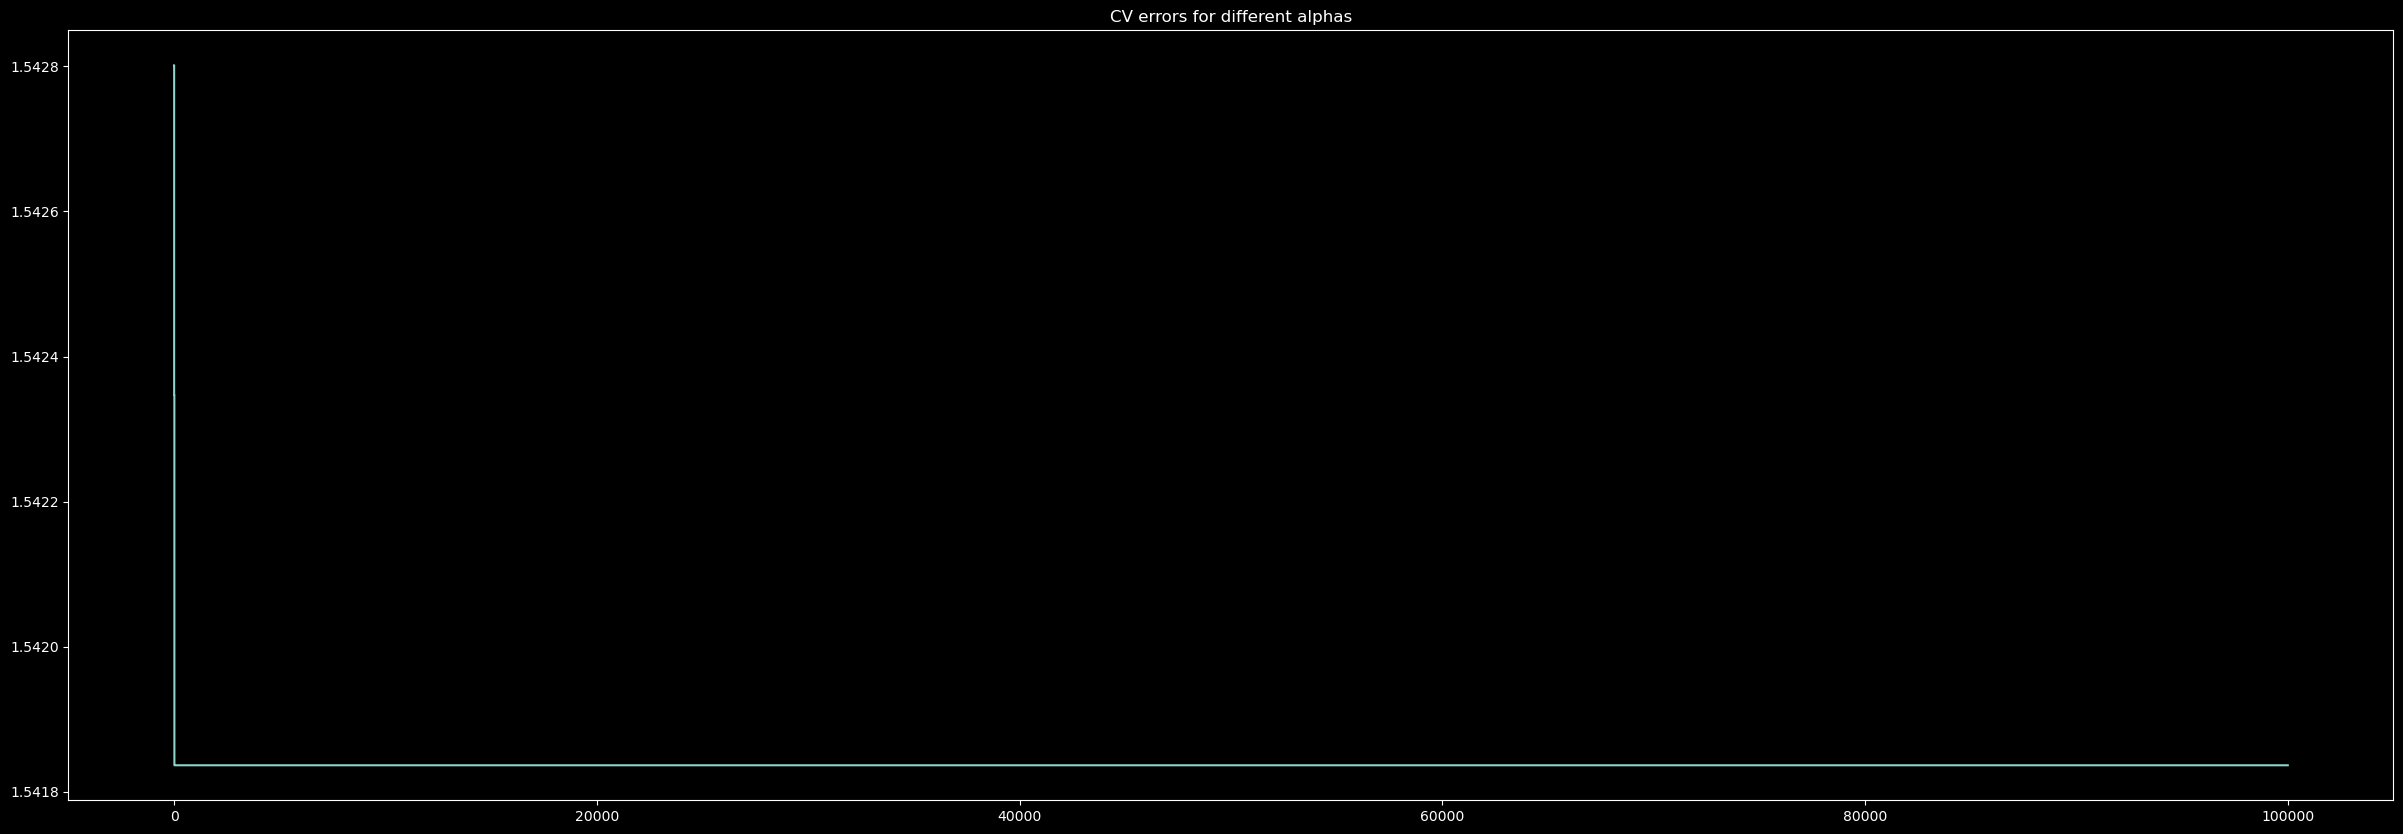

In [209]:
ridge_errs=plot_alphas_valset(data_pipe_multi.transform(X_tr),y_tr,ALPHAS,Ridge)

Kako shto gledame najdobri vrednosti vagat za mali alpha=0, shto znachit deka imat isti preformansi so ***LinearRegression***, shto znachit deka modelot ne overfitvit, tuku underfitvit.

Nema potreba da vidime feature importance,nitu pak so dropvenje na pomalce koreliranite features, i obshto da go probame na test datasetot, bidejki ako ***alpha=0*** togash ***Ridge==LinearRegression***.

## Finding alpha with scalled multicolinear dataset

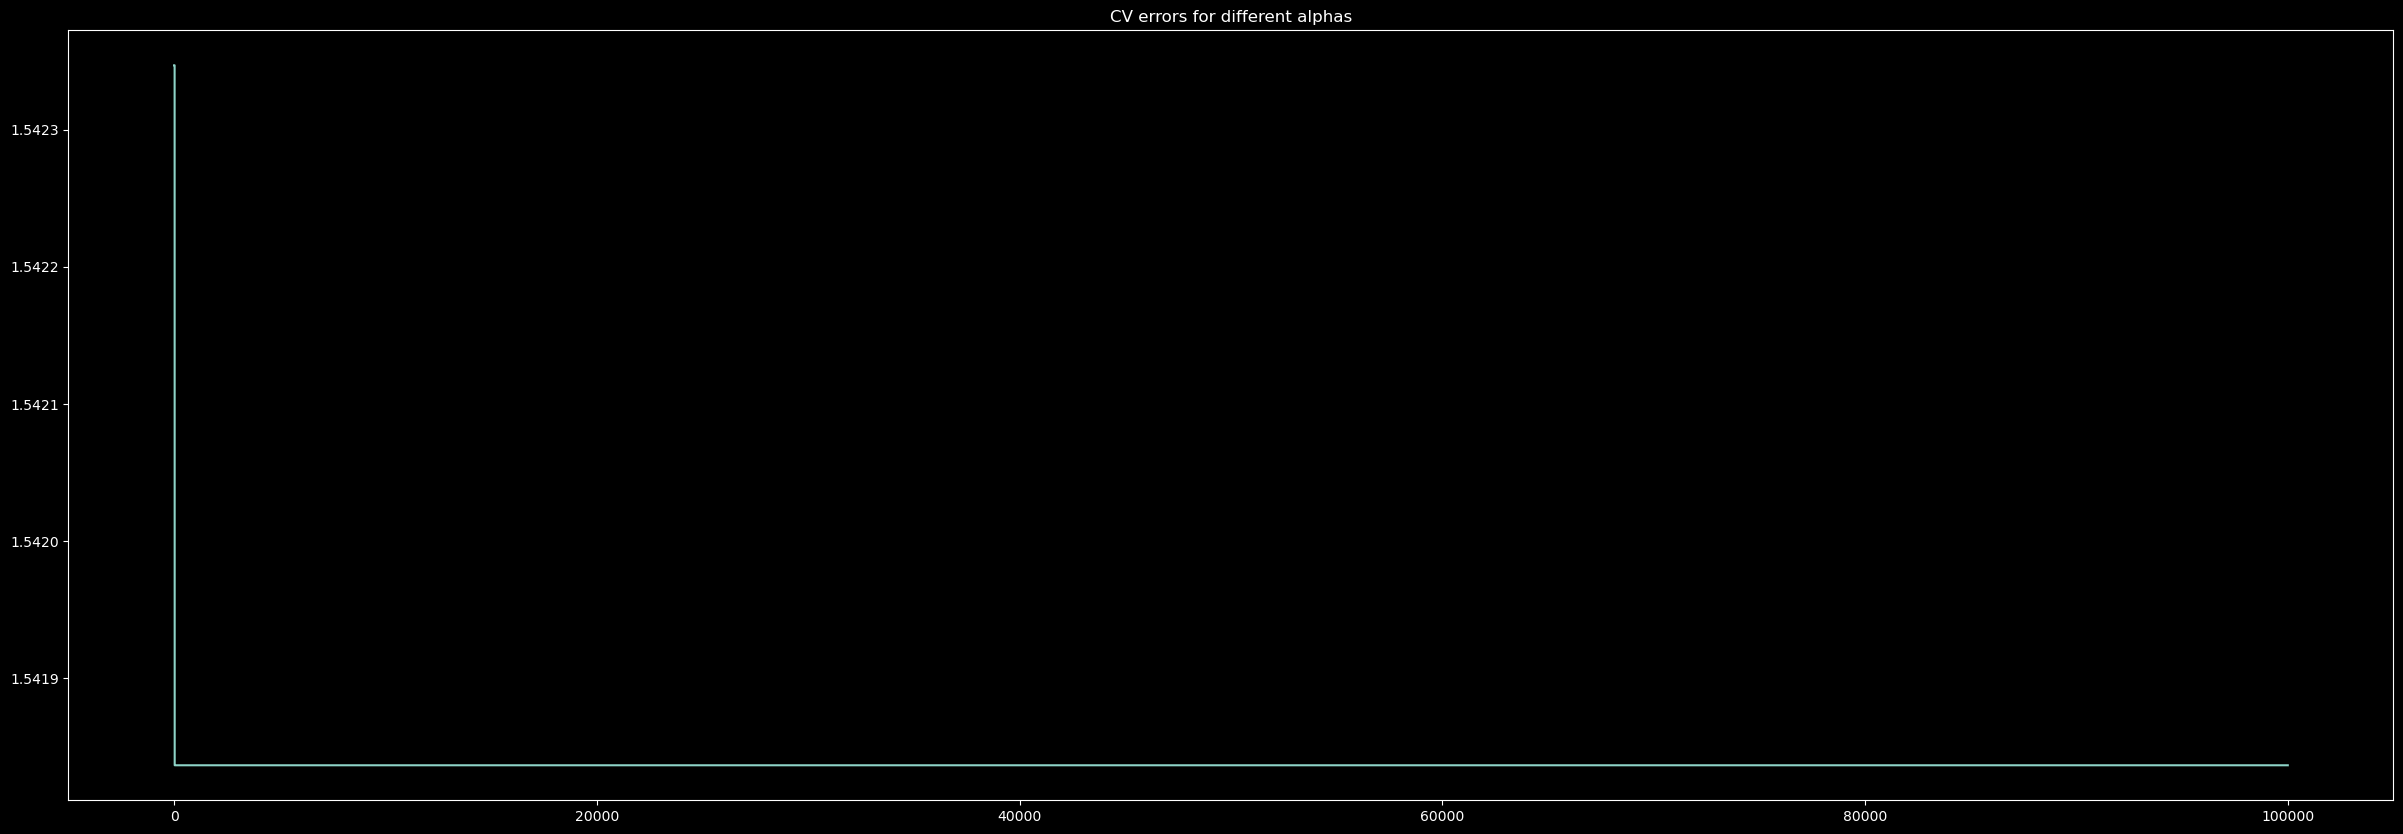

In [210]:
ridge_errs=plot_alphas_valset(data_pipe_scalling.transform(X_tr),y_tr,ALPHAS,Ridge)

Spored graphikot go dobivame istiot rezultat kako vo prethodniot slucaj.

# Lasso regression 

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.229e+11, tolerance: 5.663e+08
  model = cd_fast.enet_coordinate_descent(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.260e+11, tolerance: 5.607e+08
  model = cd_fast.enet_coordinate_descent(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

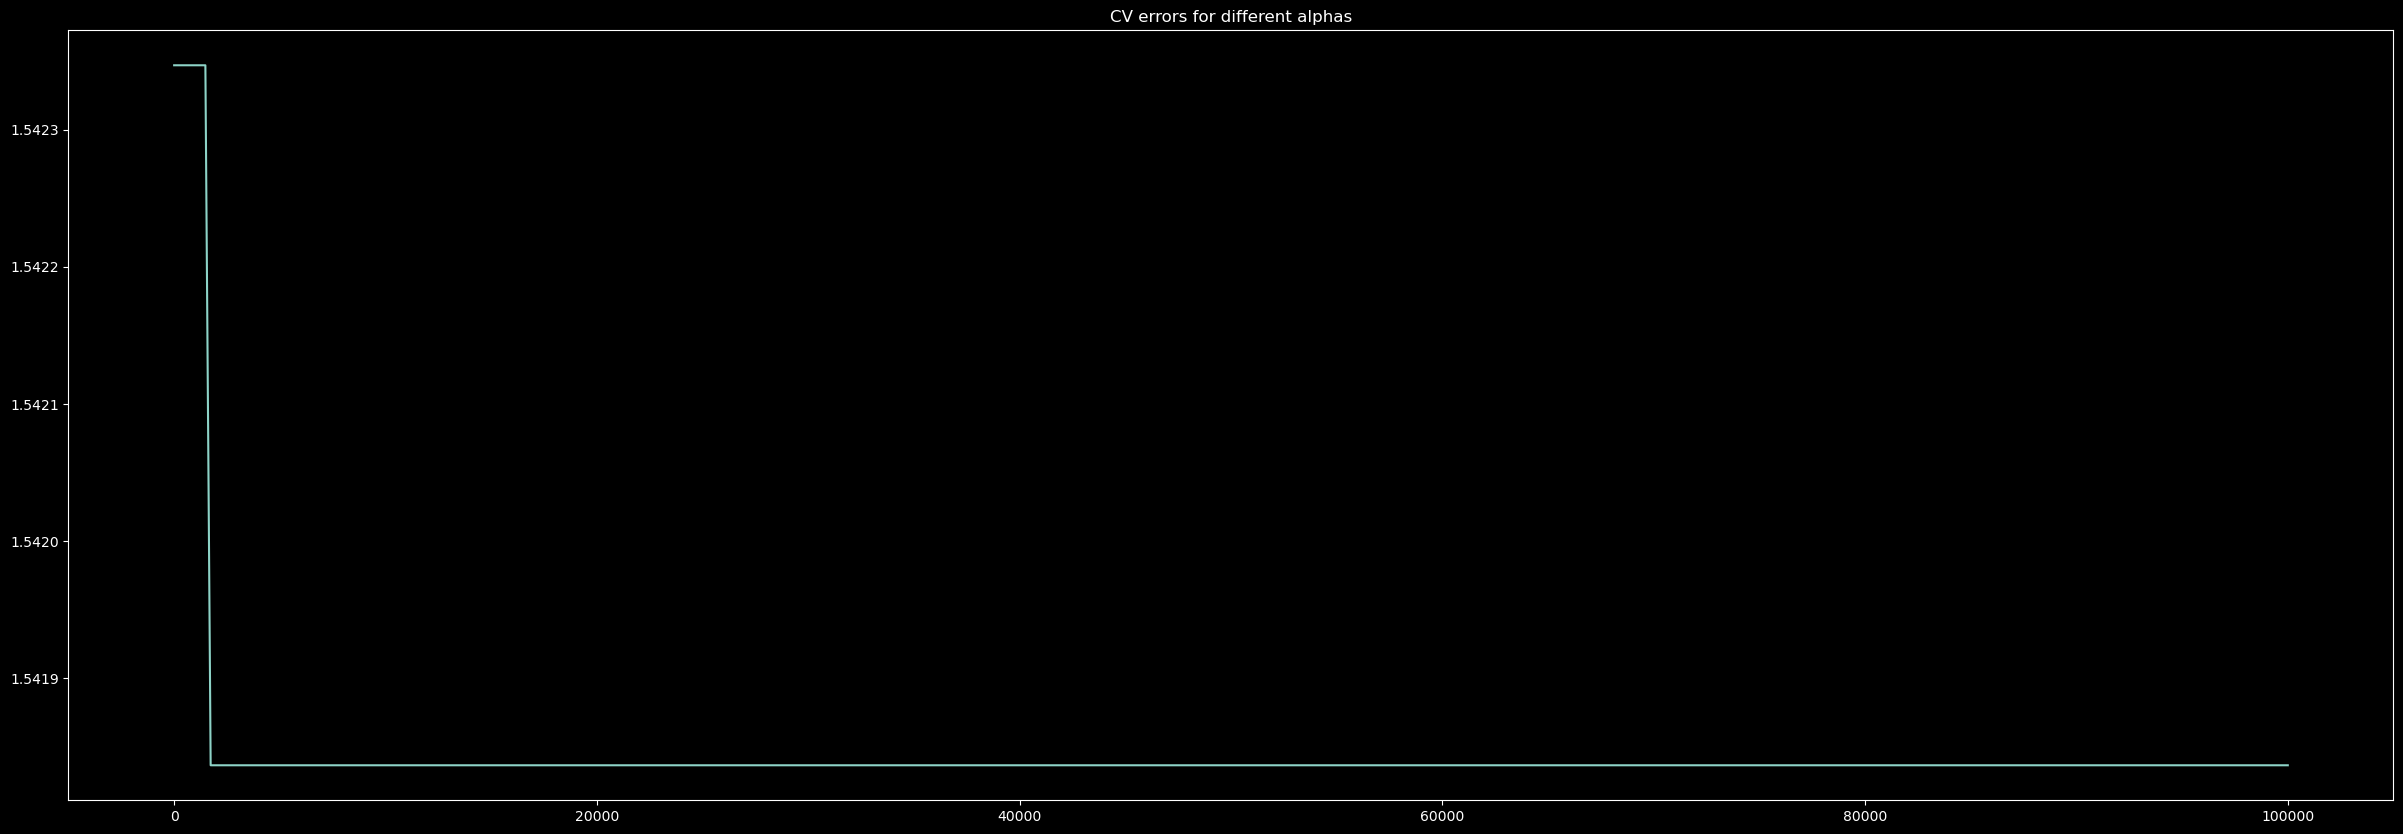

In [211]:
errs=plot_alphas_valset(data_pipe_scalling.transform(X_tr),y_tr,alphas=ALPHAS,model_constr=Lasso)

Go probav so ushte pojke cycles, nekade 1e6, ama ne konvergiraa prvite nekolku, pa si rekov mnogu vreme ke fatit za neshto sho nemat da konvergirat i go namaliv max_iter. 

In [212]:
err_min=errs.min().values[0]
errs=errs[errs==err_min].dropna()
best_alpha=errs.index.values[0]
best_alpha

1726.9832906594343

Imat smisla zsh so olku golema brojka za regularizacija. Gore vidovme ako gi dropnime kolonite sho se malce kolerirani dobivame mnogu pomal error, a lasso deka mozhit da gi dropnit barat mnogu pojke regularizacija. 

In [213]:
lasso=Lasso(alpha=best_alpha)
X_tr_proc:pd.DataFrame=data_pipe_scalling.transform(X_tr)
lasso.fit(X_tr_proc,y_tr)

Lasso(alpha=1726.9832906594343)

In [214]:
rmse_logs(Y_test,lasso.predict(data_pipe_scalling.transform(X_test)))

1.5848384489715932

Pretpostavka: Mnogu features gi nulirat.

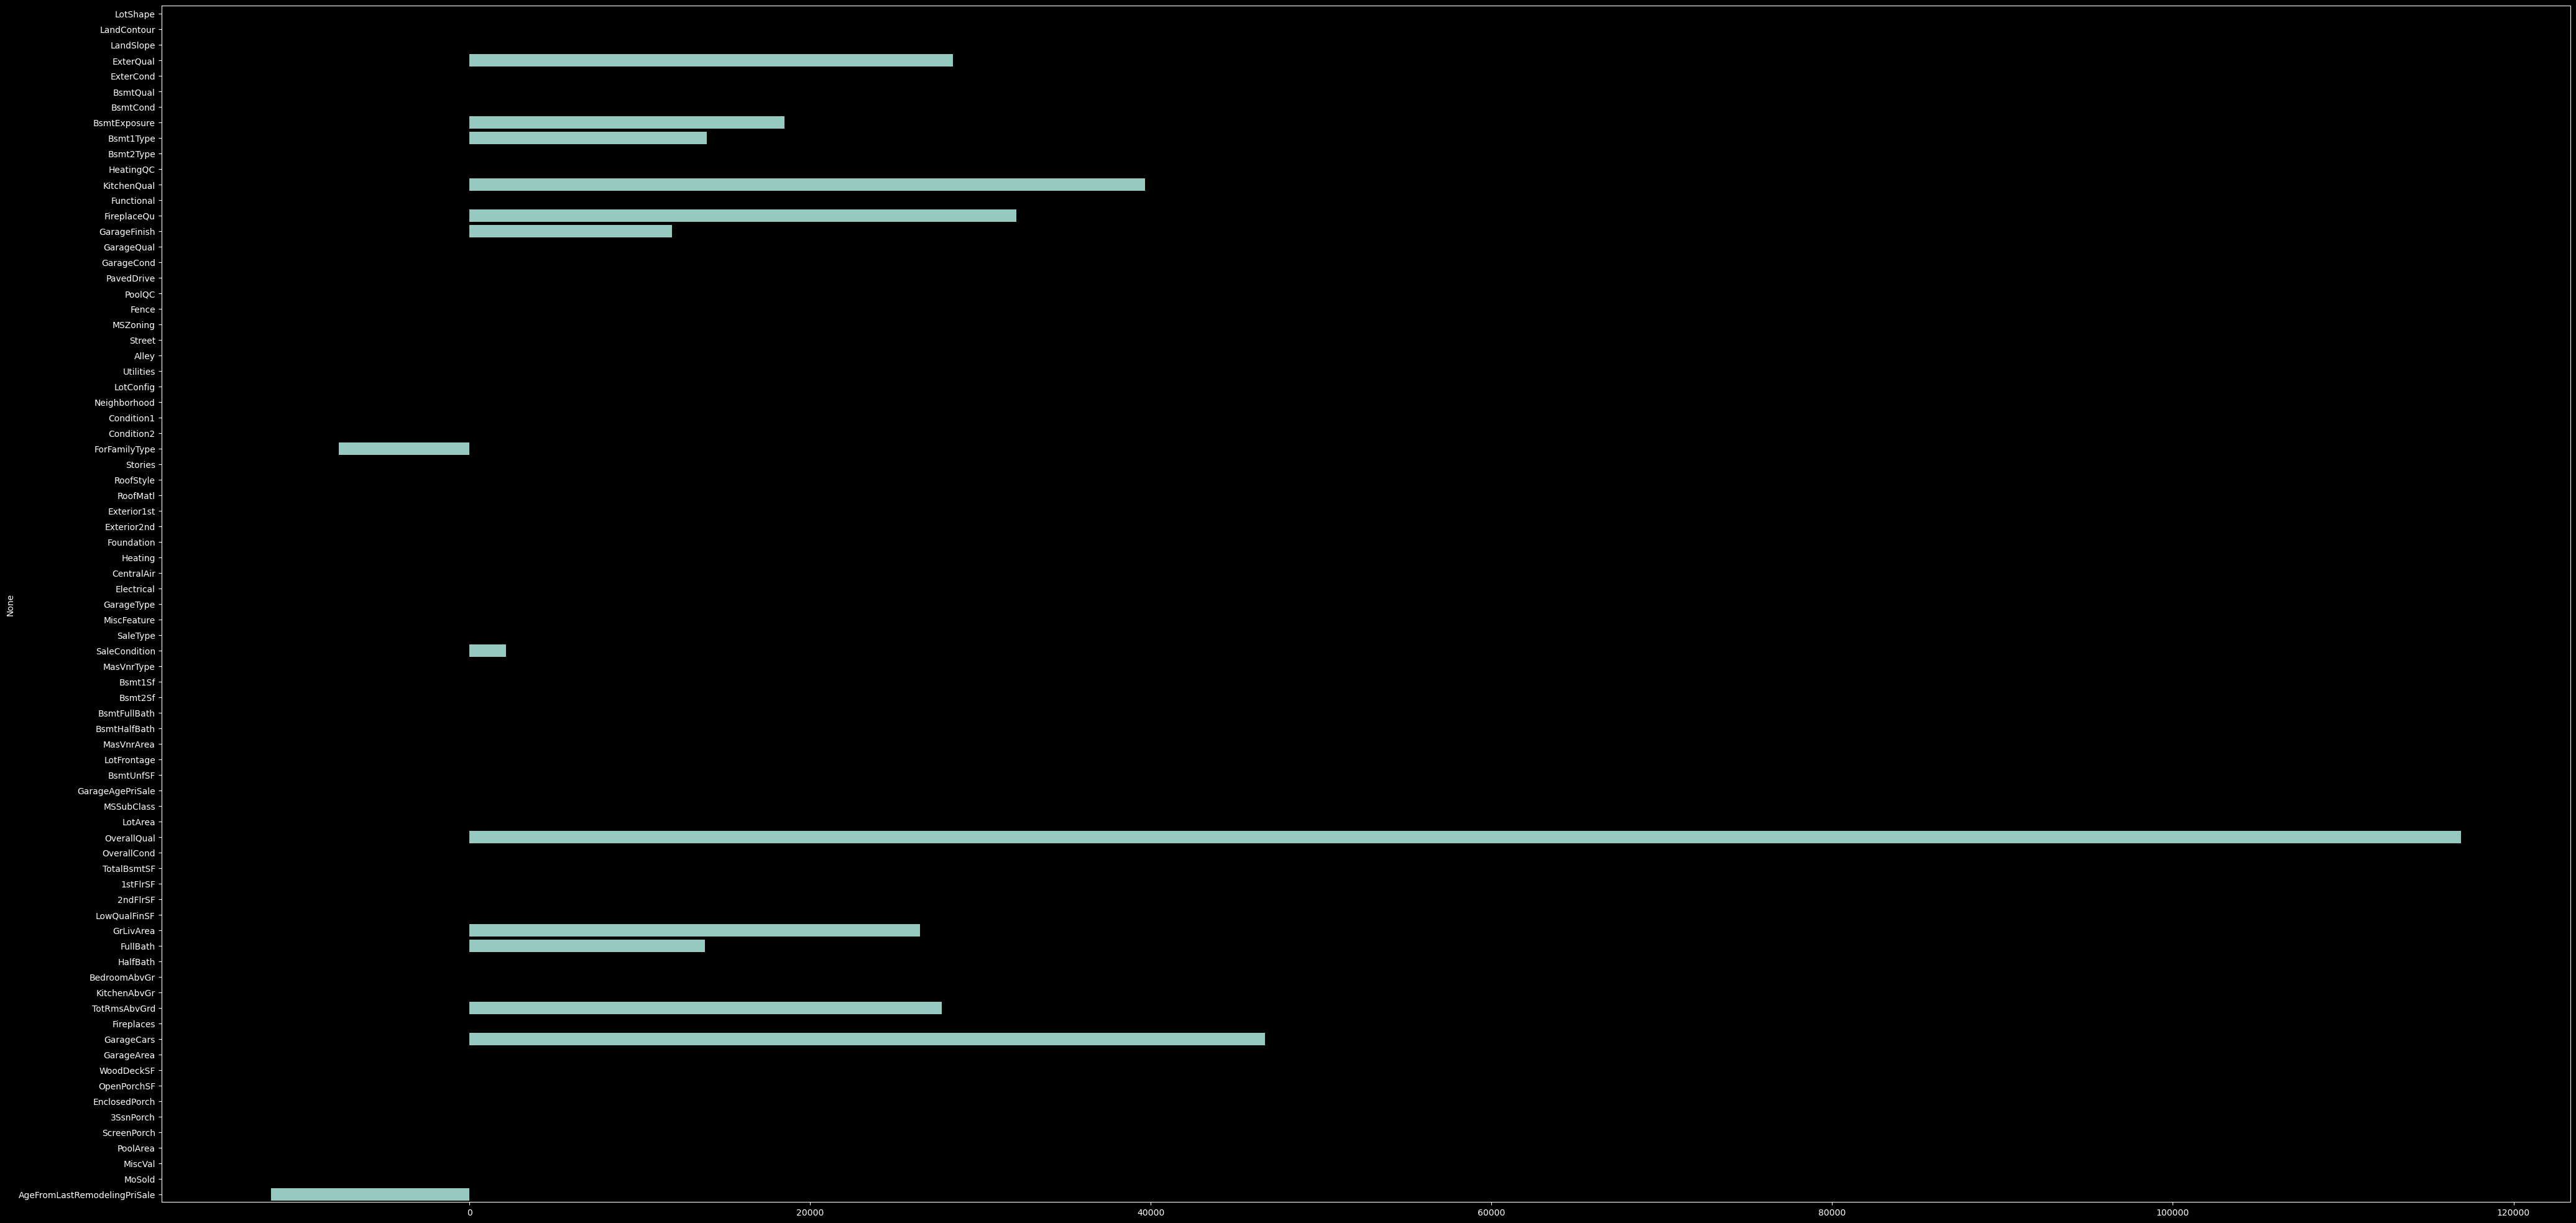

In [215]:
_=feat_imp(X_tr_proc.columns,lasso.coef_)

In [216]:
zerod_cols=np.where(lasso.coef_==0)[0]
print(zerod_cols.shape) 
zerod_cols=X_tr.columns[zerod_cols]
zerod_cols

(63,)


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape',
       'LotConfig', 'LandSlope', 'Condition1', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageArea',
       'GarageQual', 'GarageCond', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal',
       'MoSold'],
      dtype='object')

In [217]:
tmp=pd.concat([X_tr_proc,y_tr],axis=1)
cols_under_03=cols_corr_in_range(i=.3,corr=tmp.corr())
cols_under_03

array(['LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'Bsmt1Type', 'Bsmt2Type',
       'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MSZoning', 'Street', 'Alley', 'Utilities', 'LotConfig',
       'Neighborhood', 'Condition1', 'Condition2', 'ForFamilyType',
       'Stories', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType',
       'MiscFeature', 'SaleType', 'SaleCondition', 'MasVnrType',
       'Bsmt1Sf', 'Bsmt2Sf', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea',
       'LotFrontage', 'BsmtUnfSF', 'GarageAgePriSale', 'MSSubClass',
       'LotArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
  

In [218]:
zerod_cols.shape[0] - zerod_cols.isin(cols_under_03).sum() 

8

In [219]:
zerod_cols.shape[0]/data_pipe_scalling.transform(X_tr).shape[1]

0.8181818181818182

In [220]:
zerod_cols.isin(MULTICOLINEARITY_COLS).sum()/len(MULTICOLINEARITY_COLS)

0.875

Znachit deka nulirat ushte 8 features i to mu prechit na preformansite. 

# Test so dropnati multicolinear

Pretpostavka: Pomala alpha vrednost ke ni gi zadovolit potrebite.

In [221]:
X_tr_proc=data_pipe_multi.transform(X_tr)
X_test_proc=data_pipe_multi.transform(X_test)

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.618e+10, tolerance: 5.663e+08
  model = cd_fast.enet_coordinate_descent(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.277e+10, tolerance: 5.788e+08
  model = cd_fast.enet_coordinate_descent(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

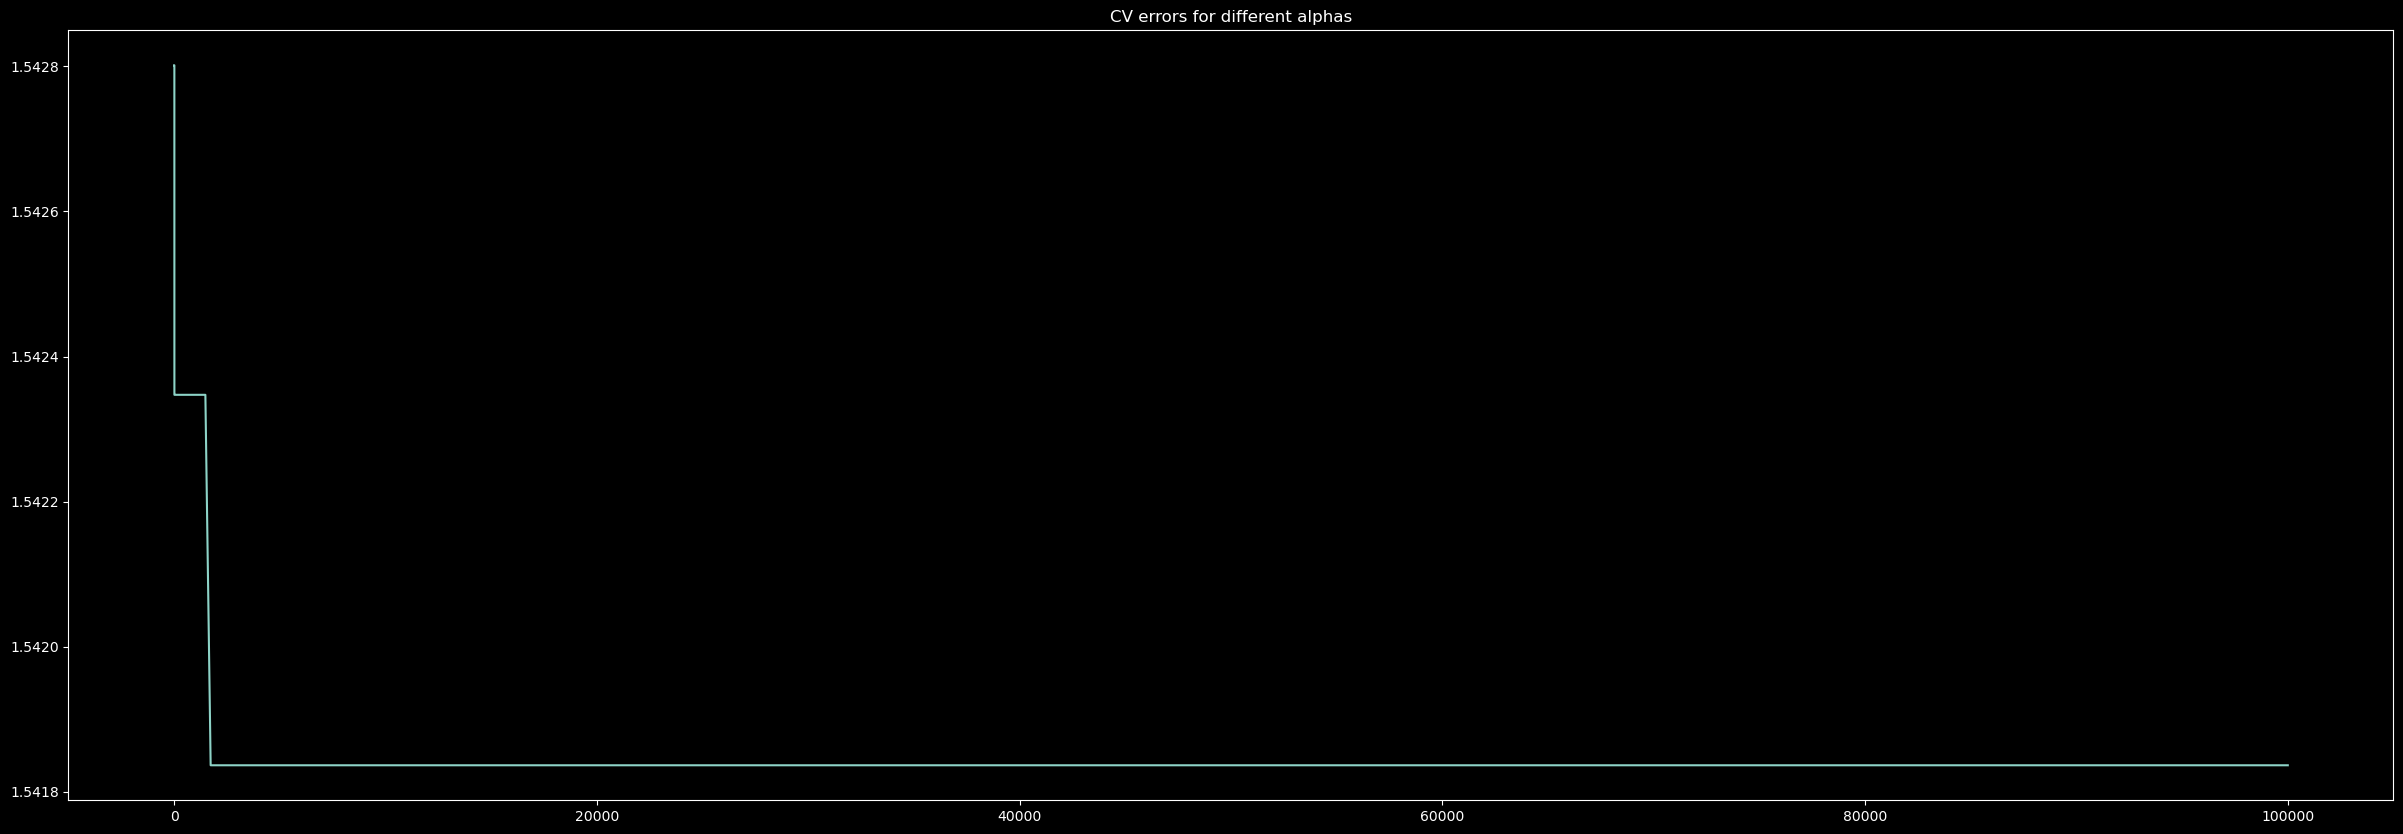

In [222]:
lasso_errs=plot_alphas_valset(X_tr_proc,y_tr,alphas=ALPHAS,model_constr=Lasso)

In [223]:
min_err=lasso_errs.min().values[0]
best_alpha=lasso_errs[lasso_errs==min_err].dropna().index.values[0]
best_alpha

1726.9832906594343

In [224]:
lasso=Lasso(alpha=best_alpha)
lasso.fit(X_test_proc,Y_test)

Lasso(alpha=1726.9832906594343)

In [225]:
rmse_logs(Y_test,lasso.predict(X_test_proc))

1.5848384489715932

In [226]:
zerod_cols=np.where(lasso.coef_==0)[0]
zerod_cols=X_tr_proc.columns[zerod_cols]
zerod_cols.shape[0]/X_tr_proc.shape[1]

0.8260869565217391

Ova ni kazvit deka najprvin gore celoto alpha mu trebalo za da skratit tie multicolinearnite features, dodeka ovaj ne se zamarat tolku so niv. Ama generalno gledame problem za generalizacija tuka. 

# Elastic net 

Vo elastic net nemat da preme drop na MULTICOLINEARITY deka modelot e spremen da se sprevit so niv. 

Pretpostavka moja e deka l1_ratio sho pomal to podobar model. Ova pretpostavka ja baziram na faktot deka vidovme podobruvanje vo preformaniste na modelite vo slucai kade shto odzemavme dosta features od datasetot. 

In [245]:
large_alphas=np.logspace(start=1,stop=5,base=10,num=20)  # 10 ** 2 ->  10 ** 4 
small_alphas=np.logspace(start=1,stop=10,base=0.1,num=20) # 0.1 -> 0.1 ** 10 

alphas=np.sort(np.concatenate([small_alphas,large_alphas]))
l1_ratio=np.linspace(0.001,stop=1,num=20)

Odbrav HalvingGridSearchCV za so cel pobrzo da se izvrshit, ama se izlazav, ich ne beshe pobrzo. 

In [246]:
fine_tuner=GridSearchCV(
    estimator=ElasticNet(max_iter=int(10e5)),
    param_grid={
        "l1_ratio": l1_ratio,
        "alpha":ALPHAS 
    },
    scoring=house_pricing_metric,
    cv=6,
    n_jobs=-1
)
fine_tuner.fit(data_pipe_scalling.transform(X_tr),y_tr)

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.884e+11, tolerance: 5.953e+08
  model = cd_fast.enet_coordinate_descent(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.884e+11, tolerance: 5.953e+08
  model = cd_fast.enet_coordinate_descent(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

KeyboardInterrupt: 

In [ ]:
fine_tuner.best_score_

1.5435126107819748

In [ ]:
best_estimator=fine_tuner.best_estimator_
best_estimator.fit(data_pipe_scalling.transform(X_tr),y_tr)

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.426e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=9.617248711152948e-09, l1_ratio=0.223, max_iter=100000)

In [ ]:
rmse_logs(Y_test,best_estimator.predict(data_pipe_scalling.transform(X_test)))

1.5848384489715932

In [ ]:
fine_tuner.cv_results_

{'iter': array([0, 0, 0, ..., 4, 4, 4]),
 'n_resources': array([ 12,  12,  12, ..., 972, 972, 972]),
 'mean_fit_time': array([2.95499961e-03, 3.17354997e-03, 2.88625558e-03, ...,
        1.32772817e+01, 8.48311985e+00, 1.51340310e+00]),
 'std_fit_time': array([6.06898281e-04, 5.18545418e-04, 3.12710164e-04, ...,
        1.00361244e+00, 6.69191737e-01, 2.82652885e-01]),
 'mean_score_time': array([0.00190087, 0.00212447, 0.00177364, ..., 0.00416255, 0.00204599,
        0.00388102]),
 'std_score_time': array([0.000411  , 0.00029969, 0.00012701, ..., 0.00085966, 0.00034162,
        0.00172569]),
 'param_alpha': masked_array(data=[1.0000000000000006e-10, 1.0000000000000006e-10,
                    1.0000000000000006e-10, ..., 2.1826447283974877e-05,
                    3.3529241492495546e-09, 7.60949668545987e-06],
              mask=[False, False, False, ..., False, False, False],
        fill_value=1e+20),
 'param_l1_ratio': masked_array(data=[0.001, 0.112, 0.223, ..., 1.0, 0.556, 0.112],

In [ ]:
splits_keys=[f'split{i}_test_score' for i in range(6)]
cv_res=fine_tuner.cv_results_
split_matrix=[]
for split_key in splits_keys:
    split_matrix.append(cv_res[split_key])
split_matrix=np.array(split_matrix)
split_matrix=split_matrix.T
cv_avrgs=[]
for split in split_matrix:
    cv_avrgs.append(np.mean(split))

In [ ]:
alphas_params=[]
l1_ratio_params=[]

for p in fine_tuner.cv_results_['params']: 
    alphas_params.append(p['alpha'])
    l1_ratio_params.append(p['l1_ratio'])

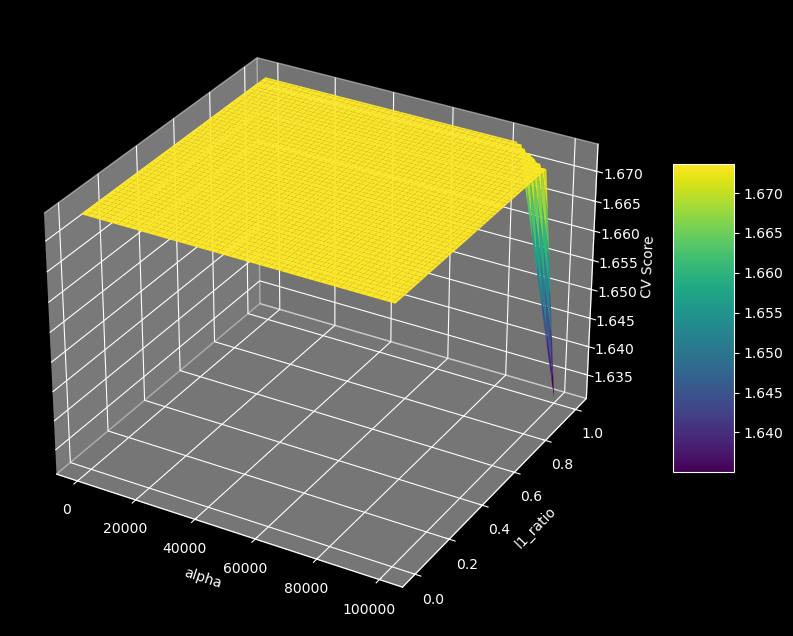

In [ ]:
import scipy.interpolate


alpha_range = np.linspace(min(alphas_params), max(alphas_params), 100)
l1_ratio_range = np.linspace(min(l1_ratio_params), max(l1_ratio_params), 100)
alpha_grid, l1_ratio_grid = np.meshgrid(alpha_range, l1_ratio_range)

Z = scipy.interpolate.griddata(
    (alphas_params, l1_ratio_params),
    cv_avrgs,
    (alpha_grid, l1_ratio_grid),
    method='linear'
)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(alpha_grid, l1_ratio_grid, Z, cmap='viridis')
ax.set_xlabel('alpha')
ax.set_ylabel('l1_ratio')
ax.set_zlabel('CV Score')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Mozhit da zaprimetime deka loss function fakat plateau, sho znachit deka okey parametri imame. 

Imat tro poloshi preformansi od Lasso i od LinearRegression, bidejki ne gi nulirat tolku strogo ko Lasso ili ko sho prevme so dropvenjeto pri LinearRegression. 

Vo grafovive za cross validation sigurni lokalnite minimumi se i globalni, zaradi conveksnosta na loss/objective funkcijata.